# Task 1
1. Operational teams rely heavily on KPIs like on-time collection and on-time delivery to gauge carrier performance. What percentage of shipments met the on-time delivery threshold (arriving no later than 30 minutes past the scheduled delivery window) between October 1st and December 31st, 2023? Please outline your assumptions.

To enhance operational efficiency by implementing proactive measures to address potential late deliveries across all shipments, ensuring timely communication and customer satisfaction.

In [2]:
#Assumptions
#1)Each SHIPMENT_NUMBER is unique and correctly identifies a single shipment across both datasets.
#2)The provided shipment bookings and GPS data are accurate, complete, and correctly represent the shipment activities within the specified period.
#3)The RECORD_TIMESTAMP in the GPS data reflects the actual time when the location was recorded so considering that assumption was made max function for RECORD_TIMESTAM would give confirmation of shipment delivery as it is historical data so max RECORD_TIMESTAM for shipment would be shipment delivered to its destination.
#4)Missing data (e.g., missing GPS records for some shipments) are assumed to be handled appropriately, ensuring that missing data do not skew the analysis results significantly.
#5)The chosen metrics (on-time delivery, early delivery, late delivery) accurately reflect the performance and are sufficient to gauge the delivery reliability.
#6)Notification thresholds for missed deliveries are assumed to be within 30 minutes, following industry standards upheld by leading courier companies like UPS, DHL, and FedEx."

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
from scipy.stats import spearmanr
from geopy.distance import distance
from geopy.extra.rate_limiter import RateLimiter
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")



# Load the datasets
shipment_bookings = pd.read_excel(r"file:///Users/ruturajabnave/Downloads/Shipment_bookings.xlsx")
gps_data = pd.read_excel(r"file:///Users/ruturajabnave/Downloads/GPS_data.xlsx")
df_nw_book = pd.read_csv(r"file:///Users/ruturajabnave/Downloads/New_bookings.csv")

In [87]:
#Exploring data
shipment_bookings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3245 entries, 0 to 3244
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   PROJECT_ID                          3245 non-null   object 
 1   SHIPMENT_NUMBER                     3245 non-null   object 
 2   CARRIER_DISPLAY_ID                  3245 non-null   object 
 3   VEHICLE_SIZE                        3245 non-null   object 
 4   VEHICLE_BUILD_UP                    3245 non-null   object 
 5   FIRST_COLLECTION_POST_CODE          3244 non-null   object 
 6   LAST_DELIVERY_POST_CODE             3241 non-null   object 
 7   FIRST_COLLECTION_LATITUDE           3245 non-null   float64
 8   FIRST_COLLECTION_LONGITUDE          3245 non-null   float64
 9   LAST_DELIVERY_LATITUDE              3245 non-null   float64
 10  LAST_DELIVERY_LONGITUDE             3245 non-null   float64
 11  FIRST_COLLECTION_SCHEDULE_EARLIEST  3245 no

In [90]:
gps_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641662 entries, 0 to 641661
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   SHIPMENT_NUMBER   641662 non-null  object 
 1   LAT               641662 non-null  float64
 2   LON               641662 non-null  float64
 3   RECORD_TIMESTAMP  641662 non-null  object 
dtypes: float64(2), object(2)
memory usage: 19.6+ MB


In [9]:
df_nw_book.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   SHIPMENT_NUMBER                     1000 non-null   object 
 1   SHIPPER_ID                          1000 non-null   object 
 2   CARRIER_ID                          1000 non-null   object 
 3   VEHICLE_SIZE                        1000 non-null   object 
 4   VEHICLE_BUILD_UP                    1000 non-null   object 
 5   FIRST_COLLECTION_POST_CODE          998 non-null    object 
 6   LAST_DELIVERY_POST_CODE             1000 non-null   object 
 7   FIRST_COLLECTION_LATITUDE           1000 non-null   float64
 8   FIRST_COLLECTION_LONGITUDE          1000 non-null   float64
 9   LAST_DELIVERY_LATITUDE              1000 non-null   float64
 10  LAST_DELIVERY_LONGITUDE             1000 non-null   float64
 11  FIRST_COLLECTION_SCHEDULE_EARLIEST  1000 non

In [11]:
shipment_bookings.shape

(3245, 15)

In [95]:
gps_data.shape

(641662, 4)

In [97]:
df_nw_book.shape

(1000, 15)

In [99]:
#Value corelation
shipment_bookings["VEHICLE_SIZE"].unique()

array(['Tractor Unit', '3.5T Van', '3.5 T Van', '18T Rigid', '26T Rigid',
       '7.5T Rigid'], dtype=object)

In [101]:
shipment_bookings["VEHICLE_SIZE"] = shipment_bookings["VEHICLE_SIZE"].replace({'3.5 T Van':'3.5T Van'})

In [103]:
shipment_bookings["VEHICLE_SIZE"].unique()

array(['Tractor Unit', '3.5T Van', '18T Rigid', '26T Rigid', '7.5T Rigid'],
      dtype=object)

In [105]:
# Merge GPS data with shipment bookings on SHIPMENT_NUMBER
merged_data = pd.merge(gps_data, shipment_bookings, on='SHIPMENT_NUMBER')

In [107]:
#Exploring merged dataset
merged_data.shape

(641662, 18)

In [109]:
#Check null values
merged_data.isnull().sum()

SHIPMENT_NUMBER                         0
LAT                                     0
LON                                     0
RECORD_TIMESTAMP                        0
PROJECT_ID                              0
CARRIER_DISPLAY_ID                      0
VEHICLE_SIZE                            0
VEHICLE_BUILD_UP                        0
FIRST_COLLECTION_POST_CODE            349
LAST_DELIVERY_POST_CODE               528
FIRST_COLLECTION_LATITUDE               0
FIRST_COLLECTION_LONGITUDE              0
LAST_DELIVERY_LATITUDE                  0
LAST_DELIVERY_LONGITUDE                 0
FIRST_COLLECTION_SCHEDULE_EARLIEST      0
FIRST_COLLECTION_SCHEDULE_LATEST        0
LAST_DELIVERY_SCHEDULE_EARLIEST         0
LAST_DELIVERY_SCHEDULE_LATEST           0
dtype: int64

In [111]:
merged_data.head()

,SHIPMENT_NUMBER,LAT,LON,RECORD_TIMESTAMP,PROJECT_ID,CARRIER_DISPLAY_ID,VEHICLE_SIZE,VEHICLE_BUILD_UP,FIRST_COLLECTION_POST_CODE,LAST_DELIVERY_POST_CODE,FIRST_COLLECTION_LATITUDE,FIRST_COLLECTION_LONGITUDE,LAST_DELIVERY_LATITUDE,LAST_DELIVERY_LONGITUDE,FIRST_COLLECTION_SCHEDULE_EARLIEST,FIRST_COLLECTION_SCHEDULE_LATEST,LAST_DELIVERY_SCHEDULE_EARLIEST,LAST_DELIVERY_SCHEDULE_LATEST
0,SEZHUK-230918-245388,53.291931,-1.072948,2023-10-09T19:25:00.000+0100,3244246f-e37c-4ba4-b9b3-61416a4449ae,CAUK000250,Tractor Unit,Curtain-Side 13.6M Trailer,S80 3FY,MITCHELSTOWN,53.293393,-1.074008,52.276579,-8.258109,2023-10-09T00:00:00.000Z,2023-10-09T23:59:00.000Z,2023-10-10T11:25:00.000Z,2023-10-10T11:55:00.000Z
1,SEZHUK-230918-245388,53.400404,-1.078563,2023-10-09T19:40:00.000+0100,3244246f-e37c-4ba4-b9b3-61416a4449ae,CAUK000250,Tractor Unit,Curtain-Side 13.6M Trailer,S80 3FY,MITCHELSTOWN,53.293393,-1.074008,52.276579,-8.258109,2023-10-09T00:00:00.000Z,2023-10-09T23:59:00.000Z,2023-10-10T11:25:00.000Z,2023-10-10T11:55:00.000Z
2,SEZHUK-230918-245388,53.574182,-1.215761,2023-10-09T19:55:00.000+0100,3244246f-e37c-4ba4-b9b3-61416a4449ae,CAUK000250,Tractor Unit,Curtain-Side 13.6M Trailer,S80 3FY,MITCHELSTOWN,53.293393,-1.074008,52.276579,-8.258109,2023-10-09T00:00:00.000Z,2023-10-09T23:59:00.000Z,2023-10-10T11:25:00.000Z,2023-10-10T11:55:00.000Z
3,SEZHUK-230918-245388,53.706805,-1.336503,2023-10-09T20:10:00.000+0100,3244246f-e37c-4ba4-b9b3-61416a4449ae,CAUK000250,Tractor Unit,Curtain-Side 13.6M Trailer,S80 3FY,MITCHELSTOWN,53.293393,-1.074008,52.276579,-8.258109,2023-10-09T00:00:00.000Z,2023-10-09T23:59:00.000Z,2023-10-10T11:25:00.000Z,2023-10-10T11:55:00.000Z
4,SEZHUK-230918-245388,53.747501,-1.640298,2023-10-09T20:25:00.000+0100,3244246f-e37c-4ba4-b9b3-61416a4449ae,CAUK000250,Tractor Unit,Curtain-Side 13.6M Trailer,S80 3FY,MITCHELSTOWN,53.293393,-1.074008,52.276579,-8.258109,2023-10-09T00:00:00.000Z,2023-10-09T23:59:00.000Z,2023-10-10T11:25:00.000Z,2023-10-10T11:55:00.000Z


In [113]:
# group data & take max to know latest location of shipment

grouped_df = merged_data.groupby(['SHIPMENT_NUMBER']).agg({'RECORD_TIMESTAMP':'max'}).reset_index()


In [115]:
#This dataframe gives latest location of shipment vehicle as is most recent timestamp of vehicle 
grouped_df

,SHIPMENT_NUMBER,RECORD_TIMESTAMP
0,SEZHUK-230918-245388,2023-10-11T11:50:00.000+0100
1,SEZHUK-230919-245487,2023-11-30T15:59:00.000Z
2,SEZHUK-230919-245488,2023-10-12T13:08:00.000+0100
3,SEZHUK-230919-245489,2023-11-09T17:51:00.000Z
4,SEZHUK-230919-245490,2023-11-02T16:29:00.000Z
...,...,...
3240,SEZHUK-231228-277315,2023-12-30T09:41:00.000Z
3241,SEZHUK-231228-277382,2023-12-29T19:31:00.000Z
3242,SEZHUK-231228-277383,2023-12-29T21:52:00.000Z
3243,SEZHUK-231228-277384,2023-12-29T18:27:00.000Z


In [117]:
# The columns LAT and LON from merged_data are added to grouped_df based on matching values in SHIPMENT_NUMBER and RECORD_TIMESTAMP.

grouped_df = pd.merge(grouped_df,merged_data[['SHIPMENT_NUMBER','LAT','LON','RECORD_TIMESTAMP']],how='left',on=['SHIPMENT_NUMBER','RECORD_TIMESTAMP'])

In [119]:
#Making dataset for task 1
task1_df = pd.merge(shipment_bookings,grouped_df,how='inner',on='SHIPMENT_NUMBER')

In [43]:
task1_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3245 entries, 0 to 3244
Data columns (total 18 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   PROJECT_ID                          3245 non-null   object 
 1   SHIPMENT_NUMBER                     3245 non-null   object 
 2   CARRIER_DISPLAY_ID                  3245 non-null   object 
 3   VEHICLE_SIZE                        3245 non-null   object 
 4   VEHICLE_BUILD_UP                    3245 non-null   object 
 5   FIRST_COLLECTION_POST_CODE          3244 non-null   object 
 6   LAST_DELIVERY_POST_CODE             3241 non-null   object 
 7   FIRST_COLLECTION_LATITUDE           3245 non-null   float64
 8   FIRST_COLLECTION_LONGITUDE          3245 non-null   float64
 9   LAST_DELIVERY_LATITUDE              3245 non-null   float64
 10  LAST_DELIVERY_LONGITUDE             3245 non-null   float64
 11  FIRST_COLLECTION_SCHEDULE_EARLIEST  3245 no

In [121]:
task1_df.shape

(3245, 18)

In [123]:
task1_df.head()

,PROJECT_ID,SHIPMENT_NUMBER,CARRIER_DISPLAY_ID,VEHICLE_SIZE,VEHICLE_BUILD_UP,FIRST_COLLECTION_POST_CODE,LAST_DELIVERY_POST_CODE,FIRST_COLLECTION_LATITUDE,FIRST_COLLECTION_LONGITUDE,LAST_DELIVERY_LATITUDE,LAST_DELIVERY_LONGITUDE,FIRST_COLLECTION_SCHEDULE_EARLIEST,FIRST_COLLECTION_SCHEDULE_LATEST,LAST_DELIVERY_SCHEDULE_EARLIEST,LAST_DELIVERY_SCHEDULE_LATEST,RECORD_TIMESTAMP,LAT,LON
0,5456fcfa-5b0c-428e-b322-240d508b6660,SEZHUK-231005-250448,CAUK000096,Tractor Unit,Curtain-Side 13.6M Trailer,PE29 2XR,EH48 2FB,52.315672,-0.157664,55.877803,-3.648558,2023-10-06T09:45:00.000Z,2023-10-06T10:00:00.000Z,2023-10-09T09:55:00.000Z,2023-10-09T10:25:00.000Z,2023-10-06T10:24:00.000+0100,52.316544,-0.157263
1,eb7a9df0-4875-43d8-9060-c79c35eae2fb,SEZHUK-231217-275004,CAUK000660,Tractor Unit,Box 44ft,BD5 8LZ,RG19 4BQ,53.764125,-1.740145,51.398851,-1.231993,2023-12-19T14:20:00.000Z,2023-12-19T16:00:00.000Z,2023-12-20T06:00:00.000Z,2023-12-20T08:56:00.000Z,2023-12-20T04:08:00.000Z,53.745423,-1.702855
2,eb7a9df0-4875-43d8-9060-c79c35eae2fb,SEZHUK-231210-272018,CAUK000435,Tractor Unit,Box 44ft,BD5 8LZ,EN3 7QP,53.767302,-1.746560,51.660700,-0.022247,2023-12-14T01:20:00.000Z,2023-12-14T03:00:00.000Z,2023-12-14T07:03:00.000Z,2023-12-14T10:43:00.000Z,2023-12-14T10:18:00.000Z,51.659889,-0.024926
3,40415fe3-e446-4d1e-b141-3698b0dc47f3,SEZHUK-231211-272127,CAUK000096,Tractor Unit,Curtain-Side 13.6M Trailer,HP22 5BL,NG31 7UH,51.779657,-0.772897,52.888113,-0.634948,2023-12-13T09:00:00.000Z,2023-12-13T09:30:00.000Z,2023-12-13T15:30:00.000Z,2023-12-13T16:00:00.000Z,2023-12-13T17:22:00.000Z,52.889862,-0.634389
4,39a4e234-5d35-4d94-8e8a-b8bf6fe13953,SEZHUK-231025-256168,CAUK000155,Tractor Unit,Curtain Side,CV23 8BQ,G75 0ZZ,52.334853,-1.180450,55.735089,-4.168719,2023-11-07T14:00:00.000Z,2023-11-07T15:00:00.000Z,2023-11-07T23:00:00.000Z,2023-11-07T23:59:00.000Z,2023-11-08T03:53:00.000Z,55.845446,-3.880531


In [125]:
#Checking Duplicate
duplicates = task1_df.duplicated().any()
duplicates

False

In [127]:
#Setting up Time window as mentioned in task 1
start_date = '2023-10-01'
end_date = '2023-12-31'

# Calculate actual delivery time based on last GPS record ( Record_timestamp column is assumed to be Actual Delivery Time as max )
task1_df['RECORD_TIMESTAMP'] = pd.to_datetime(task1_df['RECORD_TIMESTAMP'], utc=True)
task1_df['ACTUAL_DELIVERY_TIME'] = task1_df['RECORD_TIMESTAMP']

# Filter for deliveries between October 1st and December 31st, 2023
filtered_df = task1_df[(task1_df['ACTUAL_DELIVERY_TIME'] >= start_date) & (task1_df['ACTUAL_DELIVERY_TIME'] <= end_date)]


In [129]:
# Convert timestamp columns to datetime objects

filtered_df['FIRST_COLLECTION_SCHEDULE_EARLIEST'] = pd.to_datetime(filtered_df['FIRST_COLLECTION_SCHEDULE_EARLIEST'])
filtered_df['FIRST_COLLECTION_SCHEDULE_LATEST'] = pd.to_datetime(filtered_df['FIRST_COLLECTION_SCHEDULE_LATEST'])
filtered_df['LAST_DELIVERY_SCHEDULE_EARLIEST'] = pd.to_datetime(filtered_df['LAST_DELIVERY_SCHEDULE_EARLIEST'])
filtered_df['LAST_DELIVERY_SCHEDULE_LATEST'] = pd.to_datetime(filtered_df['LAST_DELIVERY_SCHEDULE_LATEST'])

In [131]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3245 entries, 0 to 3244
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype              
---  ------                              --------------  -----              
 0   PROJECT_ID                          3245 non-null   object             
 1   SHIPMENT_NUMBER                     3245 non-null   object             
 2   CARRIER_DISPLAY_ID                  3245 non-null   object             
 3   VEHICLE_SIZE                        3245 non-null   object             
 4   VEHICLE_BUILD_UP                    3245 non-null   object             
 5   FIRST_COLLECTION_POST_CODE          3244 non-null   object             
 6   LAST_DELIVERY_POST_CODE             3241 non-null   object             
 7   FIRST_COLLECTION_LATITUDE           3245 non-null   float64            
 8   FIRST_COLLECTION_LONGITUDE          3245 non-null   float64            
 9   LAST_DELIVERY_LATITUDE              3245 

In [133]:
filtered_df.shape

(3245, 19)

In [135]:
# Check if delivery was on-time (within 30 minutes of scheduled latest delivery time) between earliest & latest + 30

filtered_df['ON_TIME_DELIVERY'] = np.where(((filtered_df['ACTUAL_DELIVERY_TIME'] <= 
                                   filtered_df['LAST_DELIVERY_SCHEDULE_LATEST'] + pd.Timedelta(minutes=30)) & 
                                   (filtered_df['ACTUAL_DELIVERY_TIME'] >= 
                                   filtered_df['LAST_DELIVERY_SCHEDULE_EARLIEST'])),True,False)


In [137]:
filtered_df.head()

,PROJECT_ID,SHIPMENT_NUMBER,CARRIER_DISPLAY_ID,VEHICLE_SIZE,VEHICLE_BUILD_UP,FIRST_COLLECTION_POST_CODE,LAST_DELIVERY_POST_CODE,FIRST_COLLECTION_LATITUDE,FIRST_COLLECTION_LONGITUDE,LAST_DELIVERY_LATITUDE,LAST_DELIVERY_LONGITUDE,FIRST_COLLECTION_SCHEDULE_EARLIEST,FIRST_COLLECTION_SCHEDULE_LATEST,LAST_DELIVERY_SCHEDULE_EARLIEST,LAST_DELIVERY_SCHEDULE_LATEST,RECORD_TIMESTAMP,LAT,LON,ACTUAL_DELIVERY_TIME,ON_TIME_DELIVERY
0,5456fcfa-5b0c-428e-b322-240d508b6660,SEZHUK-231005-250448,CAUK000096,Tractor Unit,Curtain-Side 13.6M Trailer,PE29 2XR,EH48 2FB,52.315672,-0.157664,55.877803,-3.648558,2023-10-06 09:45:00+00:00,2023-10-06 10:00:00+00:00,2023-10-09 09:55:00+00:00,2023-10-09 10:25:00+00:00,2023-10-06 09:24:00+00:00,52.316544,-0.157263,2023-10-06 09:24:00+00:00,False
1,eb7a9df0-4875-43d8-9060-c79c35eae2fb,SEZHUK-231217-275004,CAUK000660,Tractor Unit,Box 44ft,BD5 8LZ,RG19 4BQ,53.764125,-1.740145,51.398851,-1.231993,2023-12-19 14:20:00+00:00,2023-12-19 16:00:00+00:00,2023-12-20 06:00:00+00:00,2023-12-20 08:56:00+00:00,2023-12-20 04:08:00+00:00,53.745423,-1.702855,2023-12-20 04:08:00+00:00,False
2,eb7a9df0-4875-43d8-9060-c79c35eae2fb,SEZHUK-231210-272018,CAUK000435,Tractor Unit,Box 44ft,BD5 8LZ,EN3 7QP,53.767302,-1.746560,51.660700,-0.022247,2023-12-14 01:20:00+00:00,2023-12-14 03:00:00+00:00,2023-12-14 07:03:00+00:00,2023-12-14 10:43:00+00:00,2023-12-14 10:18:00+00:00,51.659889,-0.024926,2023-12-14 10:18:00+00:00,True
3,40415fe3-e446-4d1e-b141-3698b0dc47f3,SEZHUK-231211-272127,CAUK000096,Tractor Unit,Curtain-Side 13.6M Trailer,HP22 5BL,NG31 7UH,51.779657,-0.772897,52.888113,-0.634948,2023-12-13 09:00:00+00:00,2023-12-13 09:30:00+00:00,2023-12-13 15:30:00+00:00,2023-12-13 16:00:00+00:00,2023-12-13 17:22:00+00:00,52.889862,-0.634389,2023-12-13 17:22:00+00:00,False
4,39a4e234-5d35-4d94-8e8a-b8bf6fe13953,SEZHUK-231025-256168,CAUK000155,Tractor Unit,Curtain Side,CV23 8BQ,G75 0ZZ,52.334853,-1.180450,55.735089,-4.168719,2023-11-07 14:00:00+00:00,2023-11-07 15:00:00+00:00,2023-11-07 23:00:00+00:00,2023-11-07 23:59:00+00:00,2023-11-08 03:53:00+00:00,55.845446,-3.880531,2023-11-08 03:53:00+00:00,False


In [139]:
#Some entries have been noticed where ACTUAL_DELIVERY_TIME <LAST_DELIVERY_SCHEDULE_EARLIEST means before earlier delivery schedule time slot shipment has been delivered
filtered_df['BEFORE_ON_TIME_DELIVERY'] = np.where((filtered_df['ACTUAL_DELIVERY_TIME'] < filtered_df['LAST_DELIVERY_SCHEDULE_EARLIEST']),True,False)


In [141]:
 filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3245 entries, 0 to 3244
Data columns (total 21 columns):
 #   Column                              Non-Null Count  Dtype              
---  ------                              --------------  -----              
 0   PROJECT_ID                          3245 non-null   object             
 1   SHIPMENT_NUMBER                     3245 non-null   object             
 2   CARRIER_DISPLAY_ID                  3245 non-null   object             
 3   VEHICLE_SIZE                        3245 non-null   object             
 4   VEHICLE_BUILD_UP                    3245 non-null   object             
 5   FIRST_COLLECTION_POST_CODE          3244 non-null   object             
 6   LAST_DELIVERY_POST_CODE             3241 non-null   object             
 7   FIRST_COLLECTION_LATITUDE           3245 non-null   float64            
 8   FIRST_COLLECTION_LONGITUDE          3245 non-null   float64            
 9   LAST_DELIVERY_LATITUDE              3245 

In [143]:
filtered_df.head()

,PROJECT_ID,SHIPMENT_NUMBER,CARRIER_DISPLAY_ID,VEHICLE_SIZE,VEHICLE_BUILD_UP,FIRST_COLLECTION_POST_CODE,LAST_DELIVERY_POST_CODE,FIRST_COLLECTION_LATITUDE,FIRST_COLLECTION_LONGITUDE,LAST_DELIVERY_LATITUDE,...,FIRST_COLLECTION_SCHEDULE_EARLIEST,FIRST_COLLECTION_SCHEDULE_LATEST,LAST_DELIVERY_SCHEDULE_EARLIEST,LAST_DELIVERY_SCHEDULE_LATEST,RECORD_TIMESTAMP,LAT,LON,ACTUAL_DELIVERY_TIME,ON_TIME_DELIVERY,BEFORE_ON_TIME_DELIVERY
0,5456fcfa-5b0c-428e-b322-240d508b6660,SEZHUK-231005-250448,CAUK000096,Tractor Unit,Curtain-Side 13.6M Trailer,PE29 2XR,EH48 2FB,52.315672,-0.157664,55.877803,...,2023-10-06 09:45:00+00:00,2023-10-06 10:00:00+00:00,2023-10-09 09:55:00+00:00,2023-10-09 10:25:00+00:00,2023-10-06 09:24:00+00:00,52.316544,-0.157263,2023-10-06 09:24:00+00:00,False,True
1,eb7a9df0-4875-43d8-9060-c79c35eae2fb,SEZHUK-231217-275004,CAUK000660,Tractor Unit,Box 44ft,BD5 8LZ,RG19 4BQ,53.764125,-1.740145,51.398851,...,2023-12-19 14:20:00+00:00,2023-12-19 16:00:00+00:00,2023-12-20 06:00:00+00:00,2023-12-20 08:56:00+00:00,2023-12-20 04:08:00+00:00,53.745423,-1.702855,2023-12-20 04:08:00+00:00,False,True
2,eb7a9df0-4875-43d8-9060-c79c35eae2fb,SEZHUK-231210-272018,CAUK000435,Tractor Unit,Box 44ft,BD5 8LZ,EN3 7QP,53.767302,-1.746560,51.660700,...,2023-12-14 01:20:00+00:00,2023-12-14 03:00:00+00:00,2023-12-14 07:03:00+00:00,2023-12-14 10:43:00+00:00,2023-12-14 10:18:00+00:00,51.659889,-0.024926,2023-12-14 10:18:00+00:00,True,False
3,40415fe3-e446-4d1e-b141-3698b0dc47f3,SEZHUK-231211-272127,CAUK000096,Tractor Unit,Curtain-Side 13.6M Trailer,HP22 5BL,NG31 7UH,51.779657,-0.772897,52.888113,...,2023-12-13 09:00:00+00:00,2023-12-13 09:30:00+00:00,2023-12-13 15:30:00+00:00,2023-12-13 16:00:00+00:00,2023-12-13 17:22:00+00:00,52.889862,-0.634389,2023-12-13 17:22:00+00:00,False,False
4,39a4e234-5d35-4d94-8e8a-b8bf6fe13953,SEZHUK-231025-256168,CAUK000155,Tractor Unit,Curtain Side,CV23 8BQ,G75 0ZZ,52.334853,-1.180450,55.735089,...,2023-11-07 14:00:00+00:00,2023-11-07 15:00:00+00:00,2023-11-07 23:00:00+00:00,2023-11-07 23:59:00+00:00,2023-11-08 03:53:00+00:00,55.845446,-3.880531,2023-11-08 03:53:00+00:00,False,False


In [145]:
# Validating Results

filtered_df[['SHIPMENT_NUMBER','LAST_DELIVERY_SCHEDULE_EARLIEST','LAST_DELIVERY_SCHEDULE_LATEST','ACTUAL_DELIVERY_TIME','ON_TIME_DELIVERY','BEFORE_ON_TIME_DELIVERY']].head(10)

,SHIPMENT_NUMBER,LAST_DELIVERY_SCHEDULE_EARLIEST,LAST_DELIVERY_SCHEDULE_LATEST,ACTUAL_DELIVERY_TIME,ON_TIME_DELIVERY,BEFORE_ON_TIME_DELIVERY
0,SEZHUK-231005-250448,2023-10-09 09:55:00+00:00,2023-10-09 10:25:00+00:00,2023-10-06 09:24:00+00:00,False,True
1,SEZHUK-231217-275004,2023-12-20 06:00:00+00:00,2023-12-20 08:56:00+00:00,2023-12-20 04:08:00+00:00,False,True
2,SEZHUK-231210-272018,2023-12-14 07:03:00+00:00,2023-12-14 10:43:00+00:00,2023-12-14 10:18:00+00:00,True,False
3,SEZHUK-231211-272127,2023-12-13 15:30:00+00:00,2023-12-13 16:00:00+00:00,2023-12-13 17:22:00+00:00,False,False
4,SEZHUK-231025-256168,2023-11-07 23:00:00+00:00,2023-11-07 23:59:00+00:00,2023-11-08 03:53:00+00:00,False,False
5,SEZHUK-231109-261150,2023-11-25 12:30:00+00:00,2023-11-25 13:30:00+00:00,2023-11-25 12:54:00+00:00,True,False
6,SEZHUK-231120-264422,2023-12-08 23:00:00+00:00,2023-12-08 23:59:00+00:00,2023-12-09 02:19:00+00:00,False,False
7,SEZHUK-231129-267720,2023-12-09 05:00:00+00:00,2023-12-09 05:30:00+00:00,2023-12-09 04:23:00+00:00,False,True
8,SEZHUK-231126-266580,2023-11-27 07:37:00+00:00,2023-11-27 10:33:01+00:00,2023-11-27 12:56:00+00:00,False,False
9,SEZHUK-231122-265191,2023-11-30 02:30:00+00:00,2023-11-30 03:00:00+00:00,2023-11-29 02:26:00+00:00,False,True


In [147]:
before_on_time_delivery_counts = filtered_df['BEFORE_ON_TIME_DELIVERY'].value_counts()
before_on_time_delivery_counts

BEFORE_ON_TIME_DELIVERY
False    1873
True     1372
Name: count, dtype: int64

In [149]:
on_time_delivery_counts = filtered_df['ON_TIME_DELIVERY'].value_counts()
on_time_delivery_counts

ON_TIME_DELIVERY
False    2584
True      661
Name: count, dtype: int64

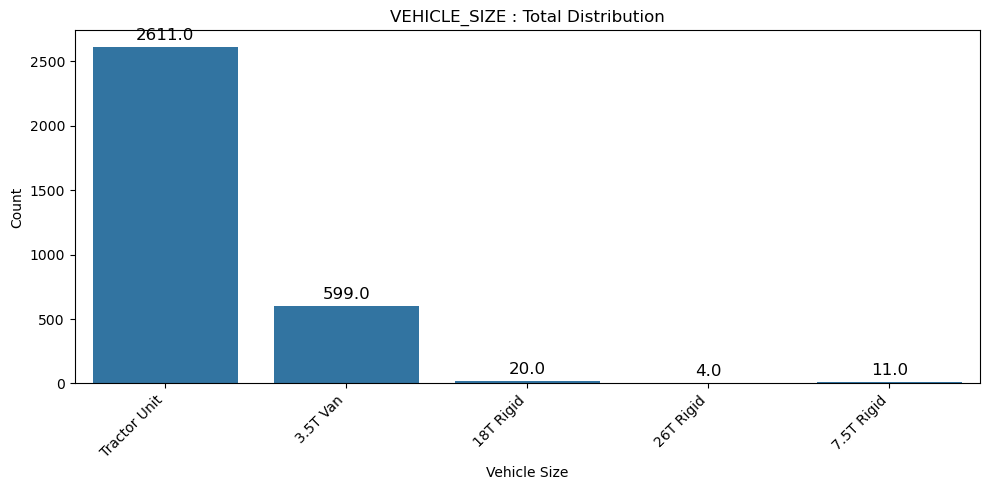

None


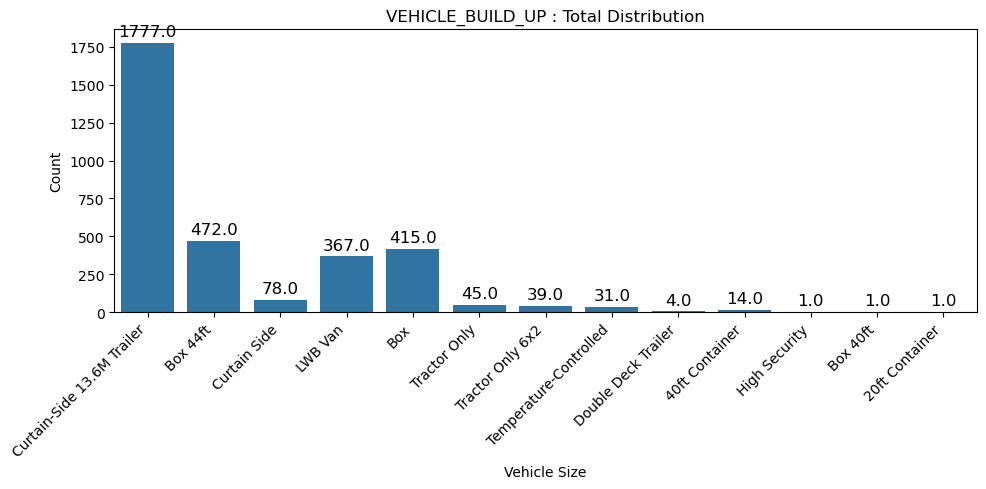

None


In [151]:
#Vehicle distribution by delivery
def countplot(column_name, data_type, dataframe):
    plt.figure(figsize=(10,5))

    ax = sns.countplot(x = dataframe[column_name]);

    # Annotate the bars with counts
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

    # Rotate x labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Vehicle Size')
    plt.ylabel('Count')
    plt.title(f'{column_name} : {data_type}')
    plt.tight_layout()
    return plt.show()

print(countplot("VEHICLE_SIZE","Total Distribution",filtered_df))
print(countplot("VEHICLE_BUILD_UP","Total Distribution",filtered_df))

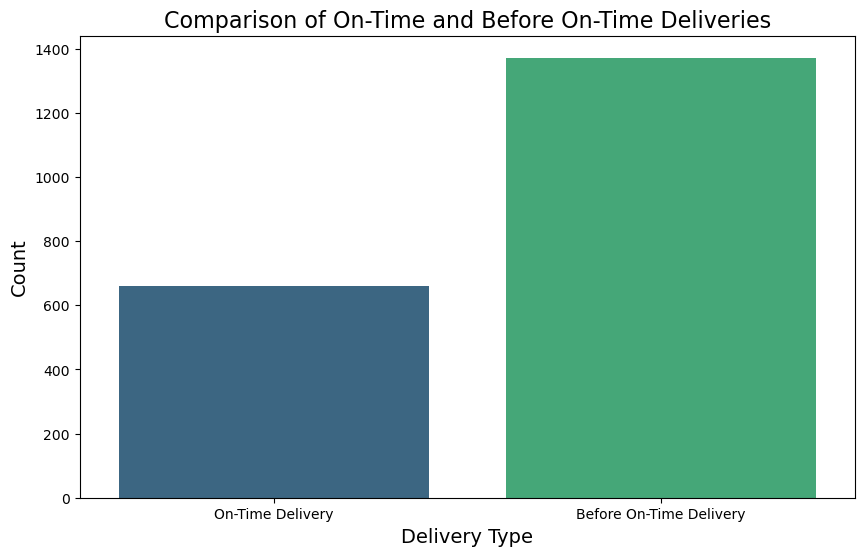

In [153]:
# Visulising on-time and before on-time deliveries
on_time_count = filtered_df['ON_TIME_DELIVERY'].sum()
before_on_time_count = filtered_df['BEFORE_ON_TIME_DELIVERY'].sum()

# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=['On-Time Delivery', 'Before On-Time Delivery'], y=[on_time_count, before_on_time_count], palette='viridis')
plt.xlabel('Delivery Type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Comparison of On-Time and Before On-Time Deliveries', fontsize=16)
plt.show()

In [155]:
# Create Total_On-Time_Deliveries column combining both conditions as both deliveries are before latest schedule delivery time and date + threshold
filtered_df['Total_On-Time_Deliveries'] = np.where(
    filtered_df['ON_TIME_DELIVERY'] | filtered_df['BEFORE_ON_TIME_DELIVERY'],
    True,
    False
)


In [159]:
#Checking value count for Total_On-Time_Deliveries
Total_Deliveries=filtered_df['Total_On-Time_Deliveries'].value_counts()
Total_Deliveries



Total_On-Time_Deliveries
True     2033
False    1212
Name: count, dtype: int64

In [161]:
#Adding column for late deliveries
filtered_df['LATE_DELIVERY'] = filtered_df['Total_On-Time_Deliveries'] == False# Filter for cases where there is a late delivery and analyze VEHICLE_SIZE
filtered_df.head(10)

,PROJECT_ID,SHIPMENT_NUMBER,CARRIER_DISPLAY_ID,VEHICLE_SIZE,VEHICLE_BUILD_UP,FIRST_COLLECTION_POST_CODE,LAST_DELIVERY_POST_CODE,FIRST_COLLECTION_LATITUDE,FIRST_COLLECTION_LONGITUDE,LAST_DELIVERY_LATITUDE,...,LAST_DELIVERY_SCHEDULE_EARLIEST,LAST_DELIVERY_SCHEDULE_LATEST,RECORD_TIMESTAMP,LAT,LON,ACTUAL_DELIVERY_TIME,ON_TIME_DELIVERY,BEFORE_ON_TIME_DELIVERY,Total_On-Time_Deliveries,LATE_DELIVERY
0,5456fcfa-5b0c-428e-b322-240d508b6660,SEZHUK-231005-250448,CAUK000096,Tractor Unit,Curtain-Side 13.6M Trailer,PE29 2XR,EH48 2FB,52.315672,-0.157664,55.877803,...,2023-10-09 09:55:00+00:00,2023-10-09 10:25:00+00:00,2023-10-06 09:24:00+00:00,52.316544,-0.157263,2023-10-06 09:24:00+00:00,False,True,True,False
1,eb7a9df0-4875-43d8-9060-c79c35eae2fb,SEZHUK-231217-275004,CAUK000660,Tractor Unit,Box 44ft,BD5 8LZ,RG19 4BQ,53.764125,-1.740145,51.398851,...,2023-12-20 06:00:00+00:00,2023-12-20 08:56:00+00:00,2023-12-20 04:08:00+00:00,53.745423,-1.702855,2023-12-20 04:08:00+00:00,False,True,True,False
2,eb7a9df0-4875-43d8-9060-c79c35eae2fb,SEZHUK-231210-272018,CAUK000435,Tractor Unit,Box 44ft,BD5 8LZ,EN3 7QP,53.767302,-1.746560,51.660700,...,2023-12-14 07:03:00+00:00,2023-12-14 10:43:00+00:00,2023-12-14 10:18:00+00:00,51.659889,-0.024926,2023-12-14 10:18:00+00:00,True,False,True,False
3,40415fe3-e446-4d1e-b141-3698b0dc47f3,SEZHUK-231211-272127,CAUK000096,Tractor Unit,Curtain-Side 13.6M Trailer,HP22 5BL,NG31 7UH,51.779657,-0.772897,52.888113,...,2023-12-13 15:30:00+00:00,2023-12-13 16:00:00+00:00,2023-12-13 17:22:00+00:00,52.889862,-0.634389,2023-12-13 17:22:00+00:00,False,False,False,True
4,39a4e234-5d35-4d94-8e8a-b8bf6fe13953,SEZHUK-231025-256168,CAUK000155,Tractor Unit,Curtain Side,CV23 8BQ,G75 0ZZ,52.334853,-1.180450,55.735089,...,2023-11-07 23:00:00+00:00,2023-11-07 23:59:00+00:00,2023-11-08 03:53:00+00:00,55.845446,-3.880531,2023-11-08 03:53:00+00:00,False,False,False,True
5,66a23663-0195-46f2-a5e4-da256bcba47b,SEZHUK-231109-261150,CAUK001009,3.5T Van,LWB Van,NP10 9DQ,DE74 2TR,51.582459,-3.043825,52.829374,...,2023-11-25 12:30:00+00:00,2023-11-25 13:30:00+00:00,2023-11-25 12:54:00+00:00,52.479792,-1.974671,2023-11-25 12:54:00+00:00,True,False,True,False
6,39a4e234-5d35-4d94-8e8a-b8bf6fe13953,SEZHUK-231120-264422,CAUK000155,Tractor Unit,Curtain Side,CV23 8BQ,ML1 4UY,52.334853,-1.180450,55.825996,...,2023-12-08 23:00:00+00:00,2023-12-08 23:59:00+00:00,2023-12-09 02:19:00+00:00,55.823052,-3.986801,2023-12-09 02:19:00+00:00,False,False,False,True
7,433732b1-4db6-4969-985d-710c0033eeb4,SEZHUK-231129-267720,CAUK000912,3.5T Van,Box,S35 2PW,LS27 0FU,53.476537,-1.471065,53.734398,...,2023-12-09 05:00:00+00:00,2023-12-09 05:30:00+00:00,2023-12-09 04:23:00+00:00,53.734287,-1.604226,2023-12-09 04:23:00+00:00,False,True,True,False
8,eb7a9df0-4875-43d8-9060-c79c35eae2fb,SEZHUK-231126-266580,CAUK001068,Tractor Unit,Box 44ft,BD5 8LZ,RG19 4BQ,53.763558,-1.739636,51.398851,...,2023-11-27 07:37:00+00:00,2023-11-27 10:33:01+00:00,2023-11-27 12:56:00+00:00,51.398914,-1.231105,2023-11-27 12:56:00+00:00,False,False,False,True
9,433732b1-4db6-4969-985d-710c0033eeb4,SEZHUK-231122-265191,CAUK000912,3.5T Van,Box,BD5 8LZ,LE3 8DX,53.766832,-1.740516,52.641456,...,2023-11-30 02:30:00+00:00,2023-11-30 03:00:00+00:00,2023-11-29 02:26:00+00:00,52.647282,-1.216005,2023-11-29 02:26:00+00:00,False,True,True,False


In [163]:
#Validating the result and comparing it for late deliveries
filtered_df[(filtered_df['ACTUAL_DELIVERY_TIME']>=filtered_df['LAST_DELIVERY_SCHEDULE_LATEST']) & 
            (filtered_df['ON_TIME_DELIVERY']== False)].head()

,PROJECT_ID,SHIPMENT_NUMBER,CARRIER_DISPLAY_ID,VEHICLE_SIZE,VEHICLE_BUILD_UP,FIRST_COLLECTION_POST_CODE,LAST_DELIVERY_POST_CODE,FIRST_COLLECTION_LATITUDE,FIRST_COLLECTION_LONGITUDE,LAST_DELIVERY_LATITUDE,...,LAST_DELIVERY_SCHEDULE_EARLIEST,LAST_DELIVERY_SCHEDULE_LATEST,RECORD_TIMESTAMP,LAT,LON,ACTUAL_DELIVERY_TIME,ON_TIME_DELIVERY,BEFORE_ON_TIME_DELIVERY,Total_On-Time_Deliveries,LATE_DELIVERY
3,40415fe3-e446-4d1e-b141-3698b0dc47f3,SEZHUK-231211-272127,CAUK000096,Tractor Unit,Curtain-Side 13.6M Trailer,HP22 5BL,NG31 7UH,51.779657,-0.772897,52.888113,...,2023-12-13 15:30:00+00:00,2023-12-13 16:00:00+00:00,2023-12-13 17:22:00+00:00,52.889862,-0.634389,2023-12-13 17:22:00+00:00,False,False,False,True
4,39a4e234-5d35-4d94-8e8a-b8bf6fe13953,SEZHUK-231025-256168,CAUK000155,Tractor Unit,Curtain Side,CV23 8BQ,G75 0ZZ,52.334853,-1.180450,55.735089,...,2023-11-07 23:00:00+00:00,2023-11-07 23:59:00+00:00,2023-11-08 03:53:00+00:00,55.845446,-3.880531,2023-11-08 03:53:00+00:00,False,False,False,True
6,39a4e234-5d35-4d94-8e8a-b8bf6fe13953,SEZHUK-231120-264422,CAUK000155,Tractor Unit,Curtain Side,CV23 8BQ,ML1 4UY,52.334853,-1.180450,55.825996,...,2023-12-08 23:00:00+00:00,2023-12-08 23:59:00+00:00,2023-12-09 02:19:00+00:00,55.823052,-3.986801,2023-12-09 02:19:00+00:00,False,False,False,True
8,eb7a9df0-4875-43d8-9060-c79c35eae2fb,SEZHUK-231126-266580,CAUK001068,Tractor Unit,Box 44ft,BD5 8LZ,RG19 4BQ,53.763558,-1.739636,51.398851,...,2023-11-27 07:37:00+00:00,2023-11-27 10:33:01+00:00,2023-11-27 12:56:00+00:00,51.398914,-1.231105,2023-11-27 12:56:00+00:00,False,False,False,True
11,bad2a1c4-4cf3-4157-864f-ce161784831f,SEZHUK-231102-258924,CAUK000689,Tractor Unit,Curtain-Side 13.6M Trailer,PR7 7NA,NP26 3TS,53.686775,-2.672518,51.572820,...,2023-11-04 10:55:00+00:00,2023-11-04 11:25:00+00:00,2023-11-04 11:58:00+00:00,51.573464,-2.858854,2023-11-04 11:58:00+00:00,False,False,False,True


#Doing EDA
#Analysis on delayed delivery and on-time delivery


In [165]:
late_Deliveries=filtered_df['LATE_DELIVERY'].value_counts()
late_Deliveries

LATE_DELIVERY
False    2033
True     1212
Name: count, dtype: int64

In [167]:
# Filter for cases where there is a late delivery and analyse VEHICLE_SIZE
late_delivery_vehicles_size = filtered_df[filtered_df['LATE_DELIVERY']]['VEHICLE_SIZE'].value_counts()
late_delivery_vehicles_size

VEHICLE_SIZE
Tractor Unit    1118
3.5T Van          63
18T Rigid         20
7.5T Rigid        11
Name: count, dtype: int64

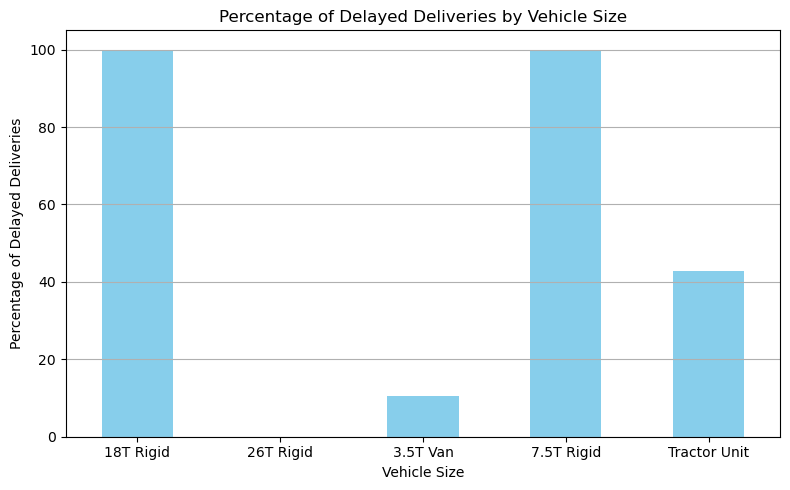

In [335]:
# Define a function to calculate the distance between the first collection and last delivery points
def calculate_distance(row):
    # Extract the starting coordinates (latitude and longitude)
    start = (row['FIRST_COLLECTION_LATITUDE'], row['FIRST_COLLECTION_LONGITUDE'])
    # Extract the ending coordinates (latitude and longitude)
    end = (row['LAST_DELIVERY_LATITUDE'], row['LAST_DELIVERY_LONGITUDE'])
    # Calculate the distance in miles between the start and end points
    return distance(start, end).miles

# Apply the calculate_distance function to each row of the filtered dataframe
# Create a new column 'DISTANCE_MILES' in the dataframe to store the calculated distances
filtered_df['DISTANCE_MILES'] = filtered_df.apply(calculate_distance, axis=1)

# Group the dataframe by 'VEHICLE_SIZE' and calculate the mean of 'LATE_DELIVERY' for each group
# Multiply by 100 to convert the proportion to a percentage
delayed_deliveries = filtered_df.groupby('VEHICLE_SIZE')['LATE_DELIVERY'].mean() * 100

# Plot the percentage of delayed deliveries by vehicle size
plt.figure(figsize=(8, 5))  # Set the size of the figure
delayed_deliveries.plot(kind='bar', color='skyblue')  # Create a bar plot with skyblue bars
plt.title('Percentage of Delayed Deliveries by Vehicle Size')  # Set the title of the plot
plt.xlabel('Vehicle Size')  # Set the label for the x-axis
plt.ylabel('Percentage of Delayed Deliveries')  # Set the label for the y-axis
plt.xticks(rotation=0)  # Set the rotation of the x-axis labels to 0 degrees
plt.grid(axis='y')  # Add grid lines along the y-axis for better readability
plt.tight_layout()  # Adjust the layout to fit all elements within the figure area
plt.show()  # Display the plot

In [171]:
total_delivery_ontime_vehicles_size = filtered_df[filtered_df['Total_On-Time_Deliveries']]['VEHICLE_SIZE'].value_counts()
total_delivery_ontime_vehicles_size

VEHICLE_SIZE
Tractor Unit    1493
3.5T Van         536
26T Rigid          4
Name: count, dtype: int64

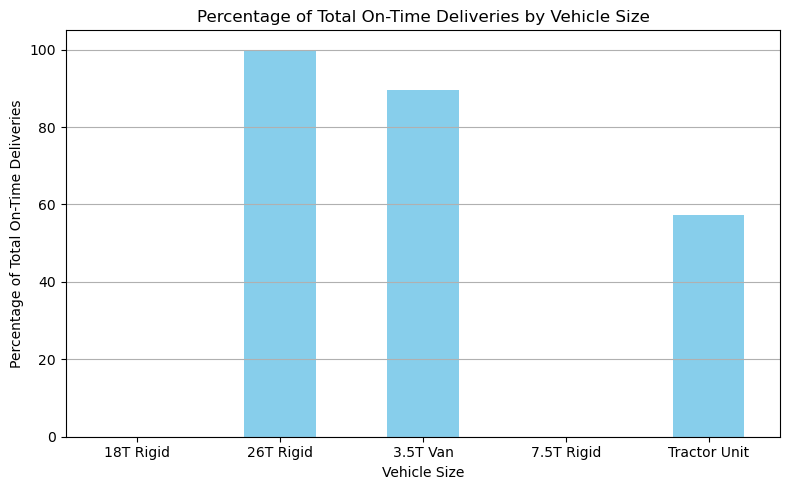

In [337]:
 # Function to calculate distance using geopy
def calculate_distance1(row):
    # Extract the starting coordinates (latitude and longitude)
    start = (row['FIRST_COLLECTION_LATITUDE'], row['FIRST_COLLECTION_LONGITUDE'])
    # Extract the ending coordinates (latitude and longitude)
    end = (row['LAST_DELIVERY_LATITUDE'], row['LAST_DELIVERY_LONGITUDE'])
    # Calculate the distance in miles between the start and end points
    return distance(start, end).miles

# Apply the calculate_distance1 function to each row of the filtered dataframe
# Create a new column 'DISTANCE_MILES' in the dataframe to store the calculated distances
filtered_df['DISTANCE_MILES'] = filtered_df.apply(calculate_distance1, axis=1)

# Group the dataframe by 'VEHICLE_SIZE' and calculate the mean of 'Total_On-Time_Deliveries' for each group
# Multiply by 100 to convert the proportion to a percentage
total_deliveries = filtered_df.groupby('VEHICLE_SIZE')['Total_On-Time_Deliveries'].mean() * 100

# Plot the percentage of total on-time deliveries by vehicle size
plt.figure(figsize=(8, 5))  # Set the size of the figure
total_deliveries.plot(kind='bar', color='skyblue')  # Create a bar plot with skyblue bars
plt.title('Percentage of Total On-Time Deliveries by Vehicle Size')  # Set the title of the plot
plt.xlabel('Vehicle Size')  # Set the label for the x-axis
plt.ylabel('Percentage of Total On-Time Deliveries')  # Set the label for the y-axis
plt.xticks(rotation=0)  # Set the rotation of the x-axis labels to 0 degrees
plt.grid(axis='y')  # Add grid lines along the y-axis for better readability
plt.tight_layout()  # Adjust the layout to fit all elements within the figure area
plt.show()  # Display the plot

In [175]:
#Exploring VEHICLE_BUILD_UP
#Calculate late deliveries for each VEHICLE_BUILD_UP
late_delivery_counts = filtered_df[filtered_df['LATE_DELIVERY']].groupby('VEHICLE_BUILD_UP').size()

# Calculate on-time (before or on-time) counts for each VEHICLE_BUILD_UP
ontime_delivery_counts = filtered_df[filtered_df['BEFORE_ON_TIME_DELIVERY']].groupby('VEHICLE_BUILD_UP').size()

# Calculate before time counts for each VEHICLE_BUILD_UP
beforetime_delivery_counts = filtered_df[filtered_df['ON_TIME_DELIVERY']].groupby('VEHICLE_BUILD_UP').size()

# Display the results
print("Late Deliveries:")
print(late_delivery_counts)
print("\nBefore Time Deliveries:")
print(beforetime_delivery_counts)
print("\nOn-time (Before or On-time) Deliveries:")
print(ontime_delivery_counts)

Late Deliveries:
VEHICLE_BUILD_UP
20ft Container                  1
40ft Container                  7
Box                            79
Box 44ft                      201
Curtain Side                   59
Curtain-Side 13.6M Trailer    784
Double Deck Trailer             3
High Security                   1
LWB Van                        44
Temperature-Controlled         16
Tractor Only                   13
Tractor Only 6x2                4
dtype: int64

Before Time Deliveries:
VEHICLE_BUILD_UP
40ft Container                  3
Box                            34
Box 40ft                        1
Box 44ft                      155
Curtain Side                   11
Curtain-Side 13.6M Trailer    294
Double Deck Trailer             1
LWB Van                       131
Temperature-Controlled         12
Tractor Only                   19
dtype: int64

On-time (Before or On-time) Deliveries:
VEHICLE_BUILD_UP
40ft Container                  4
Box                           302
Box 44ft                

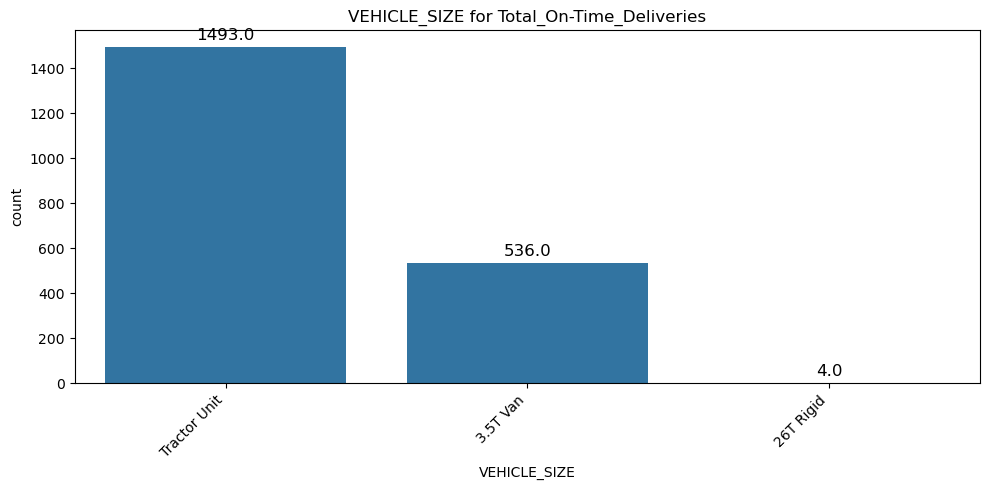

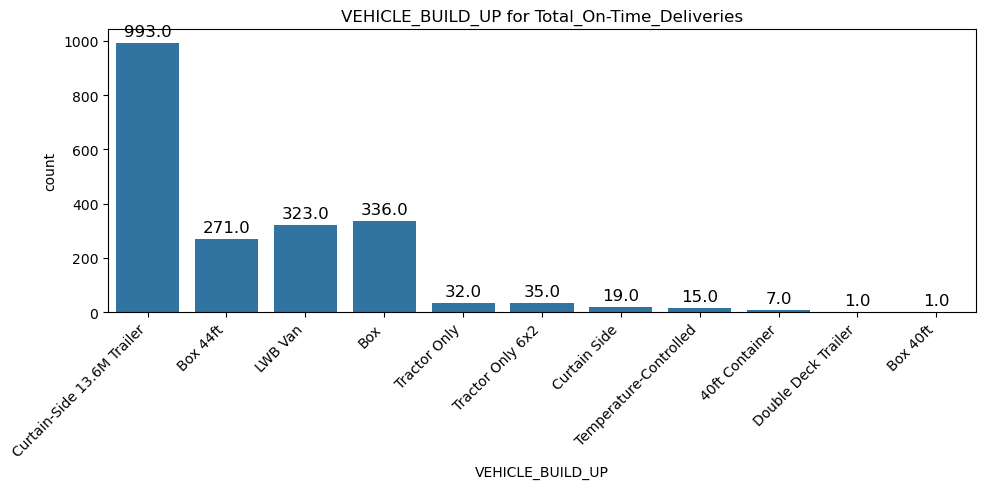

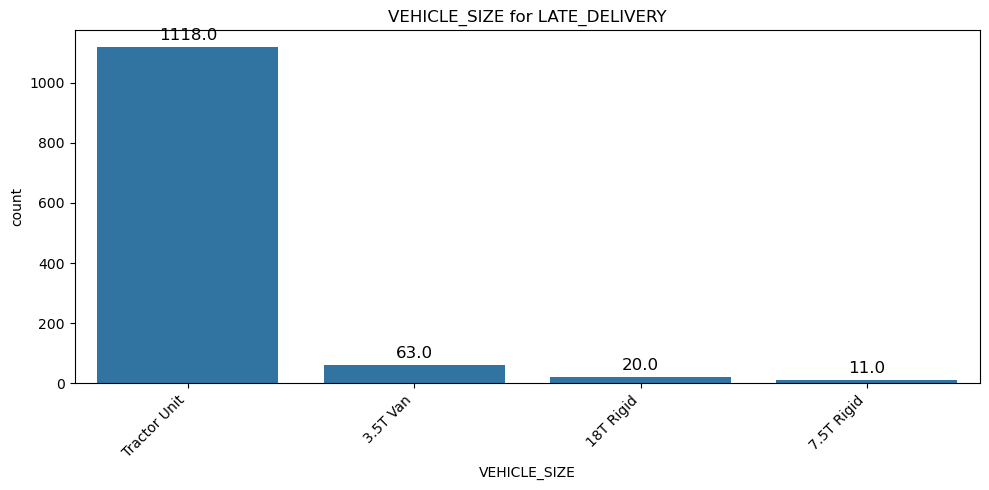

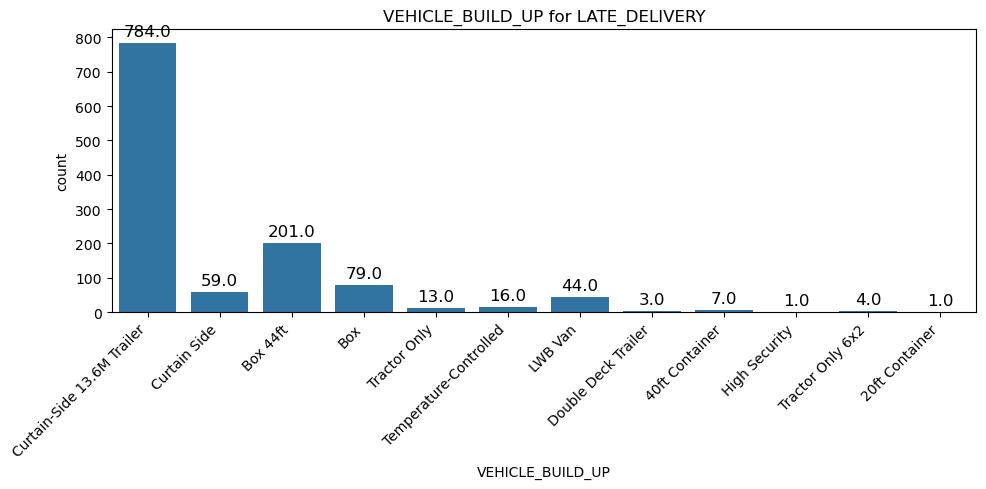

In [177]:
def countplot(column_name, target_column, dataframe):
    plt.figure(figsize=(10, 5))

    # Filter the dataframe based on the target column being True
    filtered_df = dataframe[dataframe[target_column]]

    # Create a countplot for the given column
    ax = sns.countplot(x=filtered_df[column_name])

    # Annotate the bars with counts
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')

    # Rotate x labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.title(f'{column_name} for {target_column}')
    plt.tight_layout()
    plt.show()

# Use the modified function to plot VEHICLE_SIZE and VEHICLE_BUILD_UP against Total_On-Time_Deliveries and LATE_DELIVERY
countplot("VEHICLE_SIZE", "Total_On-Time_Deliveries", filtered_df)
countplot("VEHICLE_BUILD_UP", "Total_On-Time_Deliveries", filtered_df)
countplot("VEHICLE_SIZE", "LATE_DELIVERY", filtered_df)
countplot("VEHICLE_BUILD_UP", "LATE_DELIVERY", filtered_df)

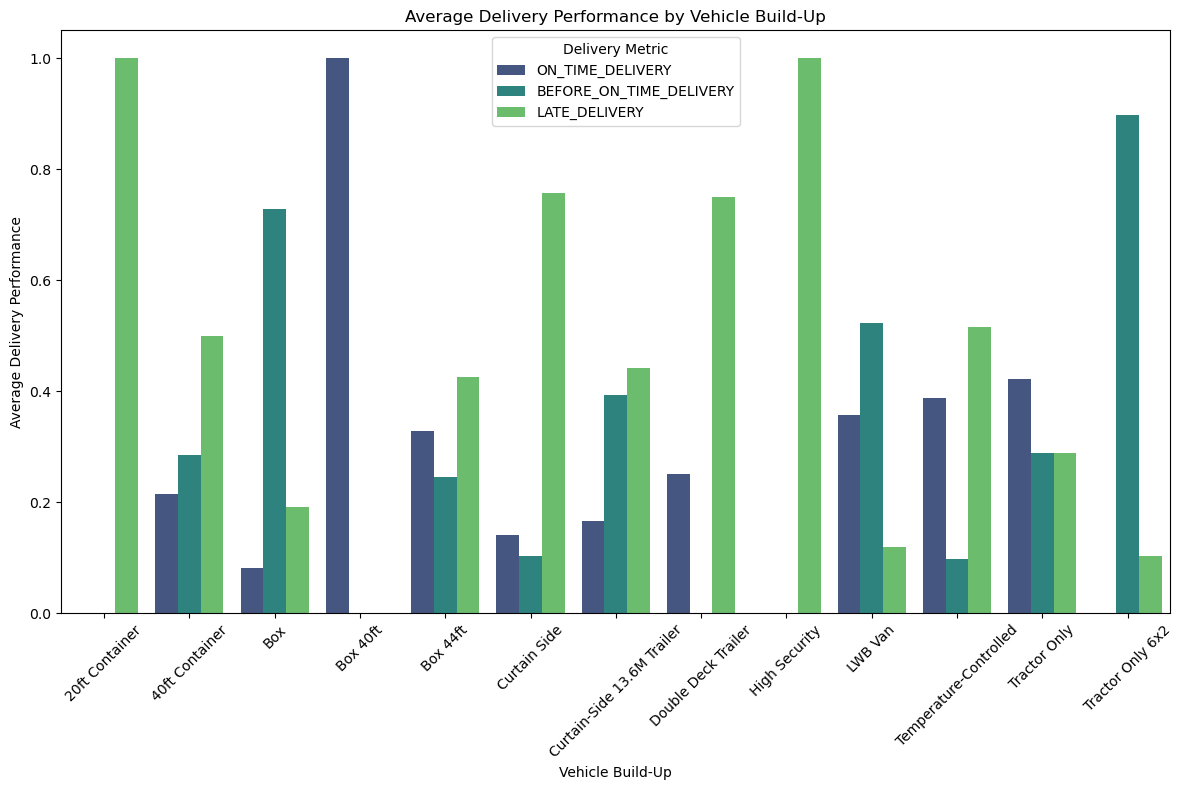

In [179]:
#Calculate average delivery metrics for different levels of VEHICLE_BUILD_UP
avg_delivery_metrics = filtered_df.groupby('VEHICLE_BUILD_UP').agg({
    'ON_TIME_DELIVERY': 'mean',
    'BEFORE_ON_TIME_DELIVERY': 'mean',
    'LATE_DELIVERY': 'mean'
}).reset_index()

# Melt the dataframe for easier plotting with seaborn
avg_delivery_metrics_melted = pd.melt(avg_delivery_metrics, id_vars=['VEHICLE_BUILD_UP'], 
                                      var_name='Delivery_Metric', value_name='Average_Delivery_Performance')

# Plot using seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='VEHICLE_BUILD_UP', y='Average_Delivery_Performance', hue='Delivery_Metric',
            data=avg_delivery_metrics_melted, palette='viridis')
plt.title('Average Delivery Performance by Vehicle Build-Up')
plt.xlabel('Vehicle Build-Up')
plt.ylabel('Average Delivery Performance')
plt.xticks(rotation=45)
plt.legend(title='Delivery Metric')
plt.tight_layout()
plt.show()

In [356]:
# Reverse Geocoding using Nominatim API
# This section initializes the Nominatim API, defines a function for reverse geocoding,
# and applies it to extract location details based on latitude and longitude coordinates
# for late, on-time, and before-time deliveries in the 'filtered_df' dataframe.


In [181]:
# Initialize Nominatim API
geolocator = Nominatim(user_agent="geoapiExercises")

# Define a function to reverse geocode
def reverse_geocode(lat, lon):
    try:
        location = geolocator.reverse((lat, lon), exactly_one=True)
        return location.address
    except:
        return None

# Use RateLimiter to throttle the API calls
reverse_geocode = RateLimiter(reverse_geocode, min_delay_seconds=1)

# Apply the function to the rows where LATE_DELIVERY is True
filtered_df['late_delivery_location'] = filtered_df.apply(
    lambda row: reverse_geocode(row['LAST_DELIVERY_LATITUDE'], row['LAST_DELIVERY_LONGITUDE']) if row['LATE_DELIVERY'] else None, 
    axis=1
)
print('Late delivery location extraction completed')

# Apply the function to the rows where BEFORE_ON_TIME_DELIVERY is True
filtered_df['ontime_delivery_location'] = filtered_df.apply(
    lambda row: reverse_geocode(row['LAST_DELIVERY_LATITUDE'], row['LAST_DELIVERY_LONGITUDE']) if row['BEFORE_ON_TIME_DELIVERY'] else None, 
    axis=1
)
print('On-time delivery location extraction completed')

# Apply the function to the rows where ON_TIME_DELIVERY is True
filtered_df['beforetime_delivery_location'] = filtered_df.apply(
    lambda row: reverse_geocode(row['LAST_DELIVERY_LATITUDE'], row['LAST_DELIVERY_LONGITUDE']) if row['ON_TIME_DELIVERY'] else None, 
    axis=1
)
print('Before time delivery location extraction completed')    


Late delivery location extraction completed
On-time delivery location extraction completed
Before time delivery location extraction completed


In [358]:
# Reverse Geocoding to Extract City Information
# 
# This section initializes the Nominatim API and defines a function to perform reverse geocoding,
# specifically extracting city information from latitude and longitude coordinates. The `reverse_geocode`
# function utilizes the geopy library and Nominatim API to retrieve the city name based on the provided
# coordinates.

In [189]:
# Initialize Nominatim API
geolocator = Nominatim(user_agent="geoapiExercises")

# Define a function to reverse geocode and extract the city
def reverse_geocode(lat, lon):
    try:
        location = geolocator.reverse((lat, lon), exactly_one=True)
        address = location.raw['address']
        city = address.get('city', address.get('town', address.get('village', '')))
        return city
    except Exception as e:
        return None

# Use RateLimiter to throttle the API calls
reverse_geocode = RateLimiter(reverse_geocode, min_delay_seconds=1)

# Apply the function to the rows where LATE_DELIVERY is True
filtered_df['late_delivery_city'] = filtered_df.apply(
    lambda row: reverse_geocode(row['LAST_DELIVERY_LATITUDE'], row['LAST_DELIVERY_LONGITUDE']) if row['LATE_DELIVERY'] else None, 
    axis=1
)
print('Late delivery city extraction completed')

# Apply the function to the rows where BEFORE_ON_TIME_DELIVERY is True
filtered_df['ontime_delivery_city'] = filtered_df.apply(
    lambda row: reverse_geocode(row['LAST_DELIVERY_LATITUDE'], row['LAST_DELIVERY_LONGITUDE']) if row['BEFORE_ON_TIME_DELIVERY'] else None, 
    axis=1
)
print('On-time delivery city extraction completed')

# Apply the function to the rows where ON_TIME_DELIVERY is True
filtered_df['beforetime_delivery_city'] = filtered_df.apply(
    lambda row: reverse_geocode(row['LAST_DELIVERY_LATITUDE'], row['LAST_DELIVERY_LONGITUDE']) if row['ON_TIME_DELIVERY'] else None, 
    axis=1
)
print('Before time delivery city extraction completed')

Late delivery city extraction completed
On-time delivery city extraction completed
Before time delivery city extraction completed


In [207]:
# Count of unidentified cities for before-time deliveries
beforetime_unidentified_count = filtered_df[filtered_df["beforetime_delivery_city"] == ""].shape[0]
print("Count of City not identified from API for before-time deliveries:", beforetime_unidentified_count)

# Count of unidentified cities for on-time deliveries
ontime_unidentified_count = filtered_df[filtered_df["ontime_delivery_city"] == ""].shape[0]
print("Count of City not identified from API for on-time deliveries:", ontime_unidentified_count)

# Count of unidentified cities for late deliveries
late_unidentified_count = filtered_df[filtered_df["late_delivery_city"] == ""].shape[0]
print("Count of City not identified from API for late deliveries:", late_unidentified_count)


Count of City not identified from API for before-time deliveries: 30
Count of City not identified from API for on-time deliveries: 55
Count of City not identified from API for late deliveries: 65


In [213]:
# Replace empty string values with "un-identified" in the specified columns
filtered_df["beforetime_delivery_city"] = filtered_df["beforetime_delivery_city"].replace({"": "un-identified"})
filtered_df["ontime_delivery_city"] = filtered_df["ontime_delivery_city"].replace({"": "un-identified"})
filtered_df["late_delivery_city"] = filtered_df["late_delivery_city"].replace({"": "un-identified"})

# Verify the replacements
print("Count of City not identified from API for before-time deliveries:", (filtered_df["beforetime_delivery_city"] == "un-identified").sum())
print("Count of City not identified from API for on-time deliveries:", (filtered_df["ontime_delivery_city"] == "un-identified").sum())
print("Count of City not identified from API for late deliveries:", (filtered_df["late_delivery_city"] == "un-identified").sum())

Count of City not identified from API for before-time deliveries: 30
Count of City not identified from API for on-time deliveries: 55
Count of City not identified from API for late deliveries: 65


In [209]:
filtered_df.to_csv("filtered_df.csv",index = False)

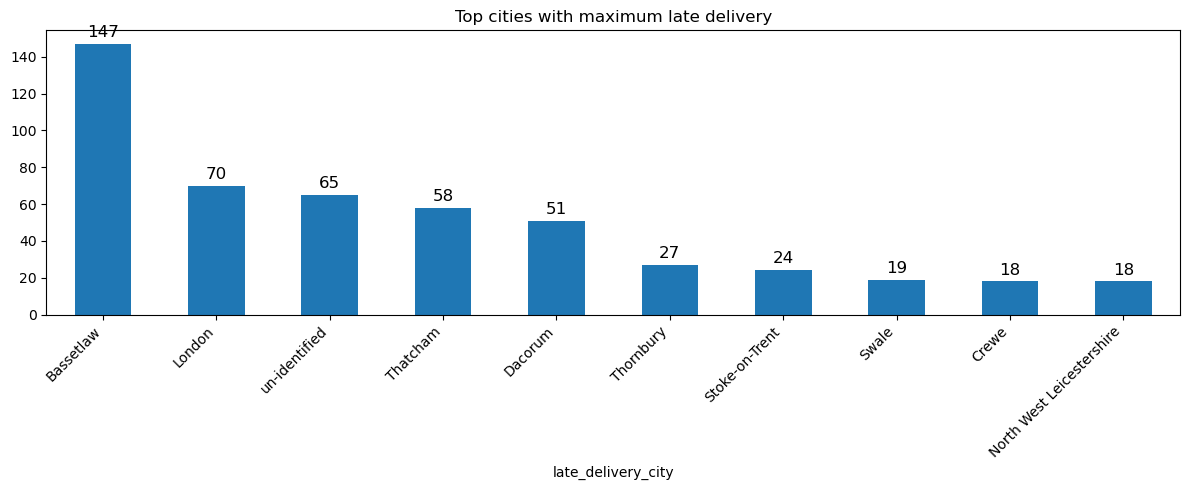

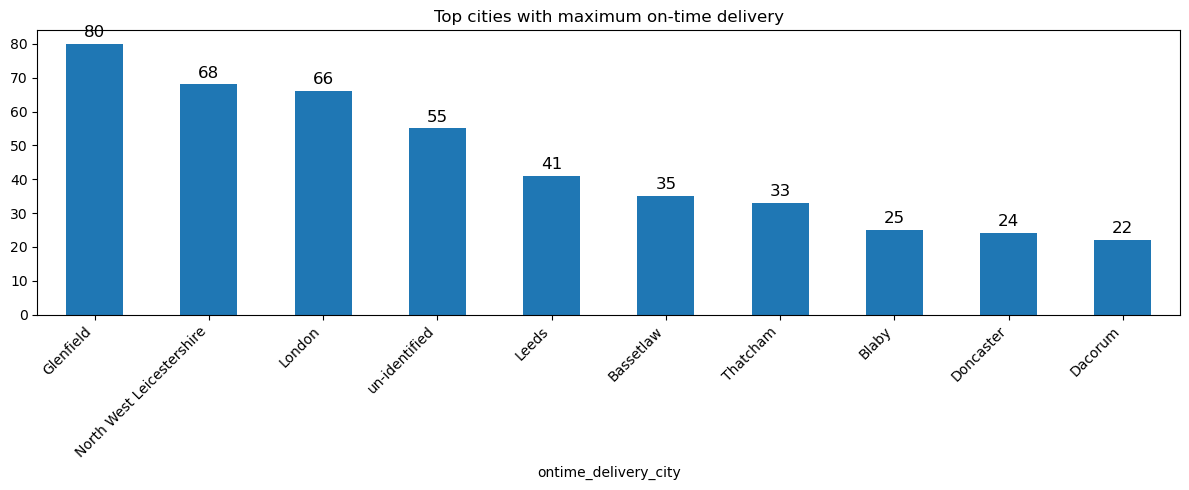

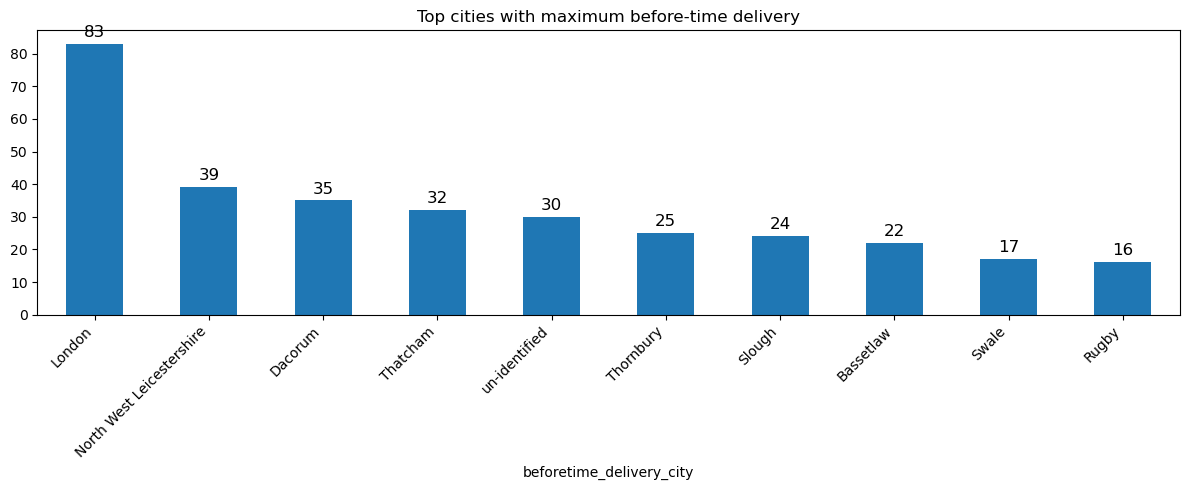

Column 'SHIPPER_ID' does not exist in the dataframe.


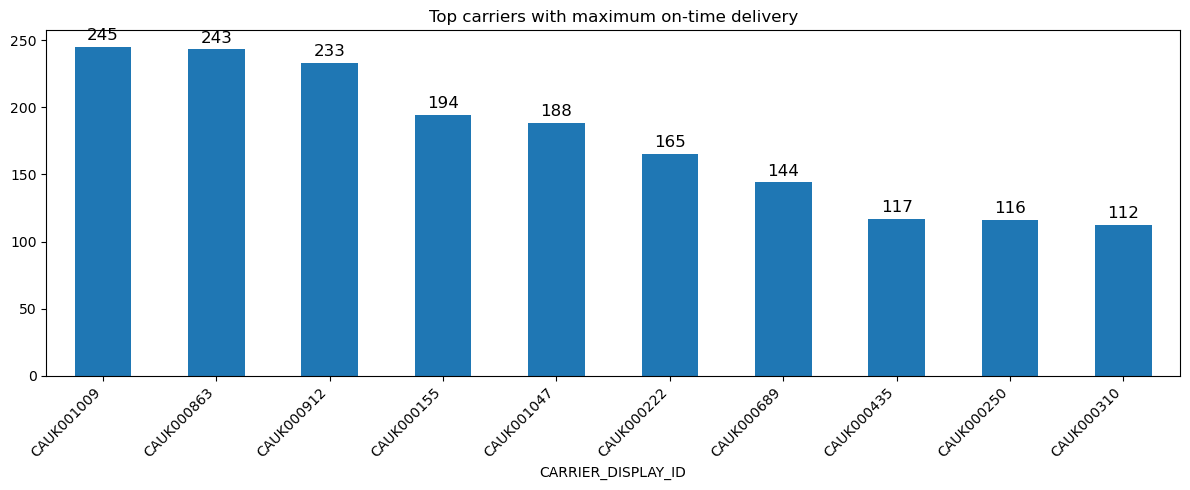

Column 'SHIPPER_ID' does not exist in the dataframe.


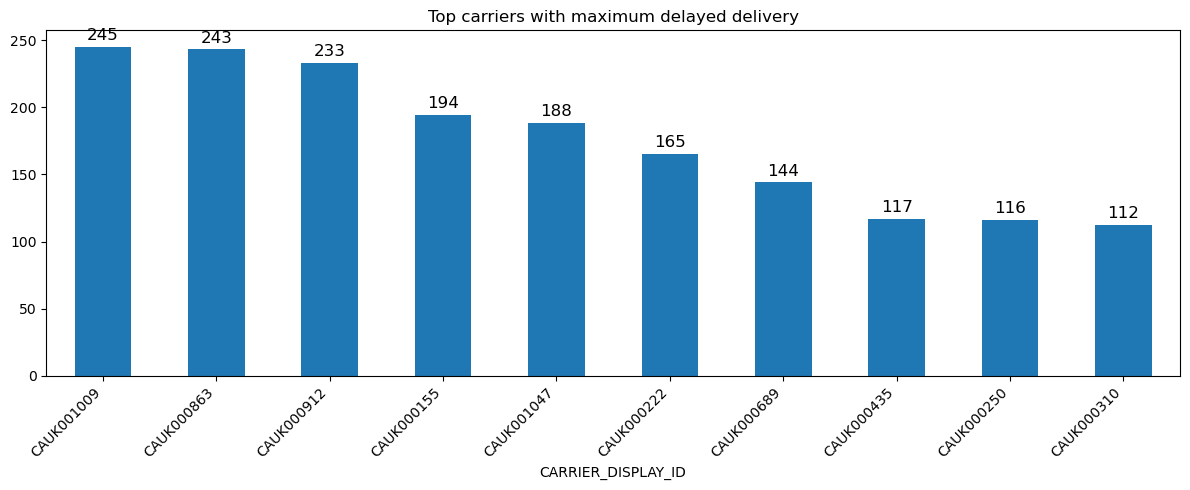

In [217]:
# Plotting function
def plottings(column, data, col_name, comment):
    # Check if the column exists
    if column not in data.columns:
        print(f"Column '{column}' does not exist in the dataframe.")
        return
    
    plt.figure(figsize=(12, 5))
    ax = data[column].value_counts().head(10).plot(kind='bar')
    
    # Annotate the bars with counts
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')
    
    # Rotate x labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Top {col_name} with maximum {comment}')
    plt.tight_layout()
    plt.show()

# Plotting the results
plottings("late_delivery_city", filtered_df, "cities", "late delivery")
plottings("ontime_delivery_city", filtered_df, "cities", "on-time delivery")
plottings("beforetime_delivery_city", filtered_df, "cities", "before-time delivery")
plottings("SHIPPER_ID", filtered_df, "shippers", "on-time delivery")
plottings("CARRIER_DISPLAY_ID", filtered_df, "carriers", "on-time delivery")
plottings("SHIPPER_ID", filtered_df, "shippers", "delayed delivery")
plottings("CARRIER_DISPLAY_ID", filtered_df, "carriers", "delayed delivery")

In [235]:
filtered_df.head()

,PROJECT_ID,SHIPMENT_NUMBER,CARRIER_DISPLAY_ID,VEHICLE_SIZE,VEHICLE_BUILD_UP,FIRST_COLLECTION_POST_CODE,LAST_DELIVERY_POST_CODE,FIRST_COLLECTION_LATITUDE,FIRST_COLLECTION_LONGITUDE,LAST_DELIVERY_LATITUDE,...,DISTANCE_MILES,late_delivery_location,ontime_delivery_location,beforetime_delivery_location,late_delivery_city,ontime_delivery_city,beforetime_delivery_city,delivery_month,delivery_day,delivery_dayofweek
0,5456fcfa-5b0c-428e-b322-240d508b6660,SEZHUK-231005-250448,CAUK000096,Tractor Unit,Curtain-Side 13.6M Trailer,PE29 2XR,EH48 2FB,52.315672,-0.157664,55.877803,...,284.232610,None,None,None,None,Bathgate,None,10,6,4
1,eb7a9df0-4875-43d8-9060-c79c35eae2fb,SEZHUK-231217-275004,CAUK000660,Tractor Unit,Box 44ft,BD5 8LZ,RG19 4BQ,53.764125,-1.740145,51.398851,...,164.940551,None,None,None,None,Thatcham,None,12,20,2
2,eb7a9df0-4875-43d8-9060-c79c35eae2fb,SEZHUK-231210-272018,CAUK000435,Tractor Unit,Box 44ft,BD5 8LZ,EN3 7QP,53.767302,-1.746560,51.660700,...,162.656589,None,None,"Brancroft Way, Brimsdown, London Borough of En...",None,None,London,12,14,3
3,40415fe3-e446-4d1e-b141-3698b0dc47f3,SEZHUK-231211-272127,CAUK000096,Tractor Unit,Curtain-Side 13.6M Trailer,HP22 5BL,NG31 7UH,51.779657,-0.772897,52.888113,...,76.863519,"Tollemache Road South, Little Ponton and Strox...",None,None,South Kesteven,None,None,12,13,2
4,39a4e234-5d35-4d94-8e8a-b8bf6fe13953,SEZHUK-231025-256168,CAUK000155,Tractor Unit,Curtain Side,CV23 8BQ,G75 0ZZ,52.334853,-1.180450,55.735089,...,264.714258,"Hurlawcrook Road, Langlands Business & Technol...",None,None,East Kilbride,None,None,11,8,2


In [233]:
filtered_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3245 entries, 0 to 3244
Data columns (total 33 columns):
 #   Column                              Non-Null Count  Dtype              
---  ------                              --------------  -----              
 0   PROJECT_ID                          3245 non-null   object             
 1   SHIPMENT_NUMBER                     3245 non-null   object             
 2   CARRIER_DISPLAY_ID                  3245 non-null   object             
 3   VEHICLE_SIZE                        3245 non-null   object             
 4   VEHICLE_BUILD_UP                    3245 non-null   object             
 5   FIRST_COLLECTION_POST_CODE          3244 non-null   object             
 6   LAST_DELIVERY_POST_CODE             3241 non-null   object             
 7   FIRST_COLLECTION_LATITUDE           3245 non-null   float64            
 8   FIRST_COLLECTION_LONGITUDE          3245 non-null   float64            
 9   LAST_DELIVERY_LATITUDE              3245 

In [360]:
#Diving deep into date time data

In [341]:
#Extract the month from 'RECORD_TIMESTAMP' and create a new column 'delivery_month'
filtered_df['delivery_month'] = filtered_df['RECORD_TIMESTAMP'].dt.month

# Extract the day of the month from 'RECORD_TIMESTAMP' and create a new column 'delivery_day'
filtered_df['delivery_day'] = filtered_df['RECORD_TIMESTAMP'].dt.day

# Extract the day of the week from 'RECORD_TIMESTAMP' and create a new column 'delivery_dayofweek'
# (0 = Monday, 1 = Tuesday, ..., 6 = Sunday)
filtered_df['delivery_dayofweek'] = filtered_df['RECORD_TIMESTAMP'].dt.dayofweek

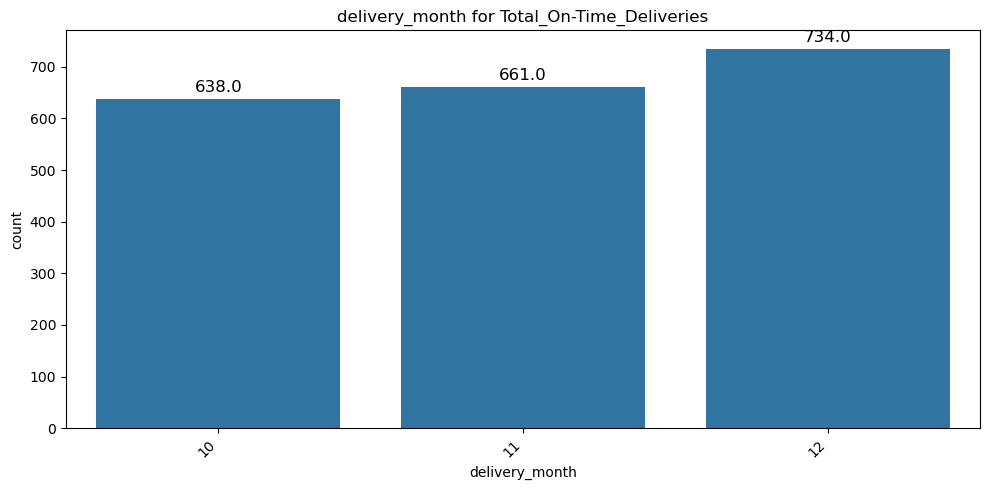

None


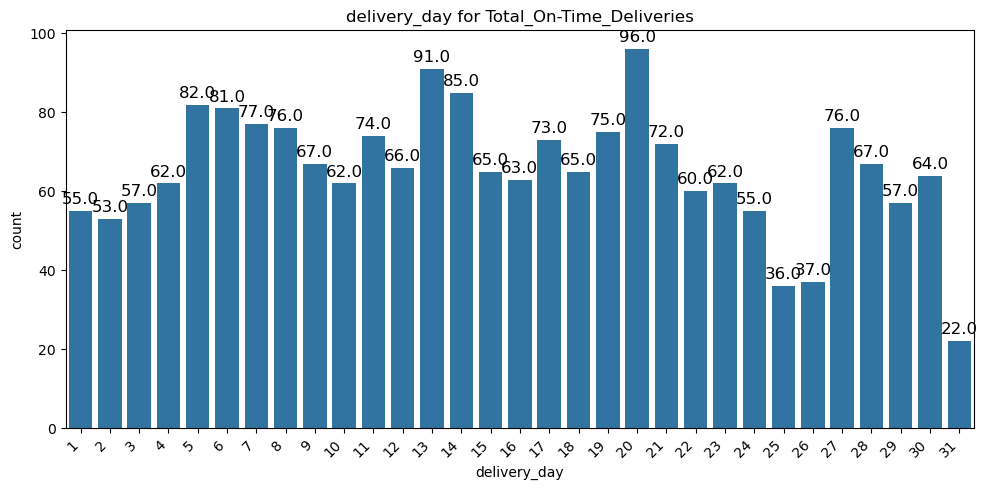

None


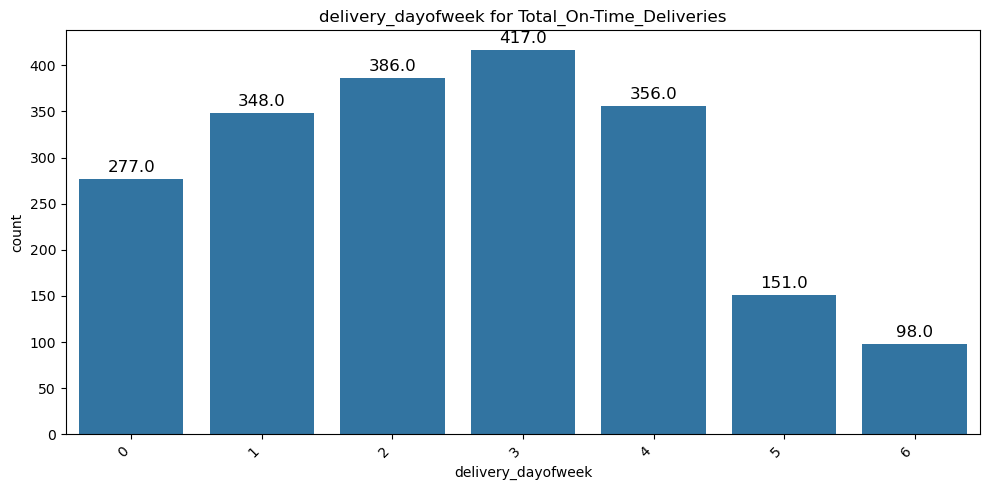

None


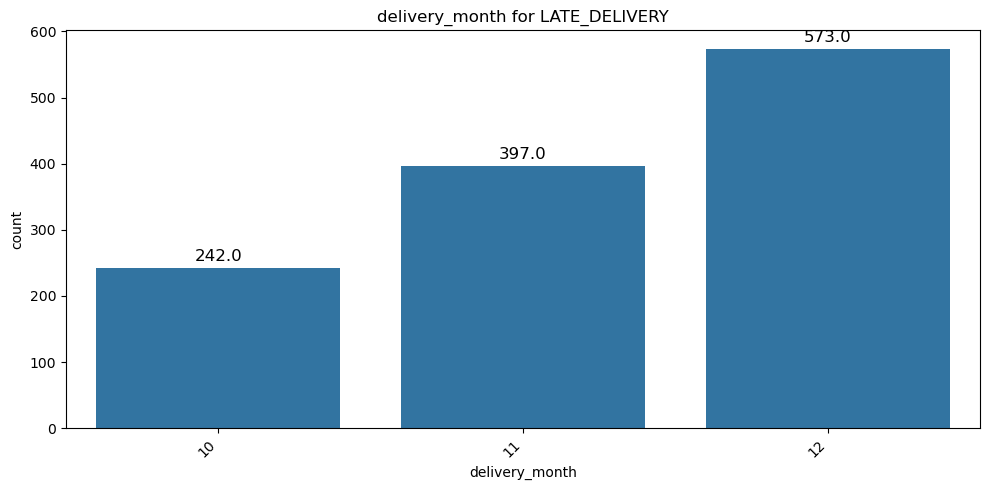

None


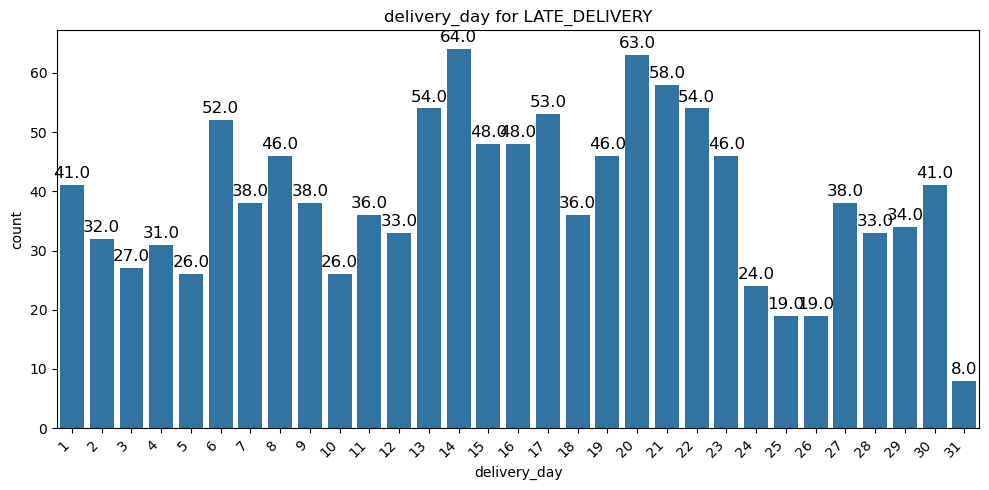

None


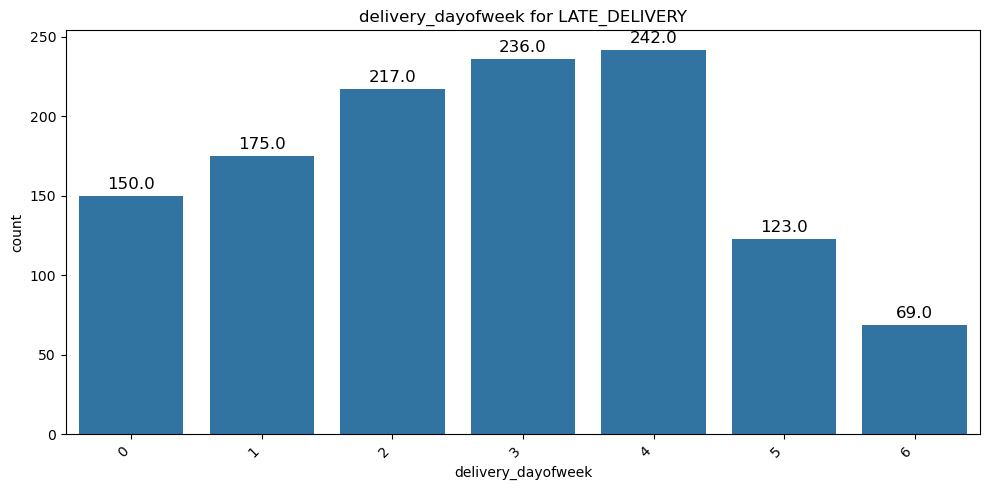

None


In [343]:
# Print the countplot for 'delivery_month' vs. 'Total_On-Time_Deliveries'
print(countplot('delivery_month', "Total_On-Time_Deliveries", filtered_df))

# Print the countplot for 'delivery_day' vs. 'Total_On-Time_Deliveries'
print(countplot('delivery_day', "Total_On-Time_Deliveries", filtered_df))

# Print the countplot for 'delivery_dayofweek' vs. 'Total_On-Time_Deliveries'
print(countplot('delivery_dayofweek', "Total_On-Time_Deliveries", filtered_df))

# Print the countplot for 'delivery_month' vs. 'LATE_DELIVERY'
print(countplot('delivery_month', "LATE_DELIVERY", filtered_df))

# Print the countplot for 'delivery_day' vs. 'LATE_DELIVERY'
print(countplot('delivery_day', "LATE_DELIVERY", filtered_df))

# Print the countplot for 'delivery_dayofweek' vs. 'LATE_DELIVERY'
print(countplot('delivery_dayofweek', "LATE_DELIVERY", filtered_df))

In [237]:
# Create a new column for Total On-Time Delivery location
filtered_df['Total_On-Time_Delivery_location'] = filtered_df.apply(
    lambda row: row['beforetime_delivery_location'] if row['beforetime_delivery_location'] is not None else row['ontime_delivery_location'], 
    axis=1
)

# Create a new column for Total On-Time Delivery city
filtered_df['Total_On-Time_Delivery_city'] = filtered_df.apply(
    lambda row: row['beforetime_delivery_city'] if row['beforetime_delivery_city'] is not None else row['ontime_delivery_city'], 
    axis=1
)

# Replace any remaining None values in the new columns with "un-identified" if needed
filtered_df['Total_On-Time_Delivery_location'] = filtered_df['Total_On-Time_Delivery_location'].replace({None: "un-identified"})
filtered_df['Total_On-Time_Delivery_city'] = filtered_df['Total_On-Time_Delivery_city'].replace({None: "un-identified"})

# Create the final_df dataframe with the new columns
final_df = filtered_df.copy()

# Verify the new columns
print(final_df[['Total_On-Time_Delivery_location', 'Total_On-Time_Delivery_city']].head())

                     Total_On-Time_Delivery_location  \
0                                      un-identified   
1                                      un-identified   
2  Brancroft Way, Brimsdown, London Borough of En...   
3                                      un-identified   
4                                      un-identified   

  Total_On-Time_Delivery_city  
0                    Bathgate  
1                    Thatcham  
2                      London  
3               un-identified  
4               un-identified  


In [331]:
final_df["Total_On-Time_Delivery_city"].value_counts().head(10)

Total_On-Time_Delivery_city
un-identified                1974
London                        149
North West Leicestershire     107
Glenfield                      83
Thatcham                       65
Bassetlaw                      57
Dacorum                        57
Slough                         45
Leeds                          41
Thornbury                      36
Name: count, dtype: int64

In [333]:
final_df["late_delivery_city"].value_counts().head(10)

late_delivery_city
Bassetlaw                    147
London                        70
un-identified                 65
Thatcham                      58
Dacorum                       51
Thornbury                     27
Stoke-on-Trent                24
Swale                         19
Crewe                         18
North West Leicestershire     18
Name: count, dtype: int64

In [243]:
final_df.head()

,PROJECT_ID,SHIPMENT_NUMBER,CARRIER_DISPLAY_ID,VEHICLE_SIZE,VEHICLE_BUILD_UP,FIRST_COLLECTION_POST_CODE,LAST_DELIVERY_POST_CODE,FIRST_COLLECTION_LATITUDE,FIRST_COLLECTION_LONGITUDE,LAST_DELIVERY_LATITUDE,...,ontime_delivery_location,beforetime_delivery_location,late_delivery_city,ontime_delivery_city,beforetime_delivery_city,delivery_month,delivery_day,delivery_dayofweek,Total_On-Time_Delivery_location,Total_On-Time_Delivery_city
0,5456fcfa-5b0c-428e-b322-240d508b6660,SEZHUK-231005-250448,CAUK000096,Tractor Unit,Curtain-Side 13.6M Trailer,PE29 2XR,EH48 2FB,52.315672,-0.157664,55.877803,...,None,None,None,Bathgate,None,10,6,4,un-identified,Bathgate
1,eb7a9df0-4875-43d8-9060-c79c35eae2fb,SEZHUK-231217-275004,CAUK000660,Tractor Unit,Box 44ft,BD5 8LZ,RG19 4BQ,53.764125,-1.740145,51.398851,...,None,None,None,Thatcham,None,12,20,2,un-identified,Thatcham
2,eb7a9df0-4875-43d8-9060-c79c35eae2fb,SEZHUK-231210-272018,CAUK000435,Tractor Unit,Box 44ft,BD5 8LZ,EN3 7QP,53.767302,-1.746560,51.660700,...,None,"Brancroft Way, Brimsdown, London Borough of En...",None,None,London,12,14,3,"Brancroft Way, Brimsdown, London Borough of En...",London
3,40415fe3-e446-4d1e-b141-3698b0dc47f3,SEZHUK-231211-272127,CAUK000096,Tractor Unit,Curtain-Side 13.6M Trailer,HP22 5BL,NG31 7UH,51.779657,-0.772897,52.888113,...,None,None,South Kesteven,None,None,12,13,2,un-identified,un-identified
4,39a4e234-5d35-4d94-8e8a-b8bf6fe13953,SEZHUK-231025-256168,CAUK000155,Tractor Unit,Curtain Side,CV23 8BQ,G75 0ZZ,52.334853,-1.180450,55.735089,...,None,None,East Kilbride,None,None,11,8,2,un-identified,un-identified


In [245]:
final_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3245 entries, 0 to 3244
Data columns (total 35 columns):
 #   Column                              Non-Null Count  Dtype              
---  ------                              --------------  -----              
 0   PROJECT_ID                          3245 non-null   object             
 1   SHIPMENT_NUMBER                     3245 non-null   object             
 2   CARRIER_DISPLAY_ID                  3245 non-null   object             
 3   VEHICLE_SIZE                        3245 non-null   object             
 4   VEHICLE_BUILD_UP                    3245 non-null   object             
 5   FIRST_COLLECTION_POST_CODE          3244 non-null   object             
 6   LAST_DELIVERY_POST_CODE             3241 non-null   object             
 7   FIRST_COLLECTION_LATITUDE           3245 non-null   float64            
 8   FIRST_COLLECTION_LONGITUDE          3245 non-null   float64            
 9   LAST_DELIVERY_LATITUDE              3245 

In [247]:
# Delete the specified columns
# Delete unnecessary columns since their information is now represented in the new columns
columns_to_delete = [
    'ON_TIME_DELIVERY', 'BEFORE_ON_TIME_DELIVERY', 'ontime_delivery_location',
    'beforetime_delivery_location', 'beforetime_delivery_city', 'ontime_delivery_city'
]
final_df.drop(columns=columns_to_delete, inplace=True)

# Verify the new dataframe
print(final_df.head())

                             PROJECT_ID       SHIPMENT_NUMBER  \
0  5456fcfa-5b0c-428e-b322-240d508b6660  SEZHUK-231005-250448   
1  eb7a9df0-4875-43d8-9060-c79c35eae2fb  SEZHUK-231217-275004   
2  eb7a9df0-4875-43d8-9060-c79c35eae2fb  SEZHUK-231210-272018   
3  40415fe3-e446-4d1e-b141-3698b0dc47f3  SEZHUK-231211-272127   
4  39a4e234-5d35-4d94-8e8a-b8bf6fe13953  SEZHUK-231025-256168   

  CARRIER_DISPLAY_ID  VEHICLE_SIZE            VEHICLE_BUILD_UP  \
0         CAUK000096  Tractor Unit  Curtain-Side 13.6M Trailer   
1         CAUK000660  Tractor Unit                    Box 44ft   
2         CAUK000435  Tractor Unit                    Box 44ft   
3         CAUK000096  Tractor Unit  Curtain-Side 13.6M Trailer   
4         CAUK000155  Tractor Unit                Curtain Side   

  FIRST_COLLECTION_POST_CODE LAST_DELIVERY_POST_CODE  \
0                   PE29 2XR                EH48 2FB   
1                    BD5 8LZ                RG19 4BQ   
2                    BD5 8LZ                

In [249]:
final_df.head()

,PROJECT_ID,SHIPMENT_NUMBER,CARRIER_DISPLAY_ID,VEHICLE_SIZE,VEHICLE_BUILD_UP,FIRST_COLLECTION_POST_CODE,LAST_DELIVERY_POST_CODE,FIRST_COLLECTION_LATITUDE,FIRST_COLLECTION_LONGITUDE,LAST_DELIVERY_LATITUDE,...,Total_On-Time_Deliveries,LATE_DELIVERY,DISTANCE_MILES,late_delivery_location,late_delivery_city,delivery_month,delivery_day,delivery_dayofweek,Total_On-Time_Delivery_location,Total_On-Time_Delivery_city
0,5456fcfa-5b0c-428e-b322-240d508b6660,SEZHUK-231005-250448,CAUK000096,Tractor Unit,Curtain-Side 13.6M Trailer,PE29 2XR,EH48 2FB,52.315672,-0.157664,55.877803,...,True,False,284.232610,None,None,10,6,4,un-identified,Bathgate
1,eb7a9df0-4875-43d8-9060-c79c35eae2fb,SEZHUK-231217-275004,CAUK000660,Tractor Unit,Box 44ft,BD5 8LZ,RG19 4BQ,53.764125,-1.740145,51.398851,...,True,False,164.940551,None,None,12,20,2,un-identified,Thatcham
2,eb7a9df0-4875-43d8-9060-c79c35eae2fb,SEZHUK-231210-272018,CAUK000435,Tractor Unit,Box 44ft,BD5 8LZ,EN3 7QP,53.767302,-1.746560,51.660700,...,True,False,162.656589,None,None,12,14,3,"Brancroft Way, Brimsdown, London Borough of En...",London
3,40415fe3-e446-4d1e-b141-3698b0dc47f3,SEZHUK-231211-272127,CAUK000096,Tractor Unit,Curtain-Side 13.6M Trailer,HP22 5BL,NG31 7UH,51.779657,-0.772897,52.888113,...,False,True,76.863519,"Tollemache Road South, Little Ponton and Strox...",South Kesteven,12,13,2,un-identified,un-identified
4,39a4e234-5d35-4d94-8e8a-b8bf6fe13953,SEZHUK-231025-256168,CAUK000155,Tractor Unit,Curtain Side,CV23 8BQ,G75 0ZZ,52.334853,-1.180450,55.735089,...,False,True,264.714258,"Hurlawcrook Road, Langlands Business & Technol...",East Kilbride,11,8,2,un-identified,un-identified


In [251]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3245 entries, 0 to 3244
Data columns (total 29 columns):
 #   Column                              Non-Null Count  Dtype              
---  ------                              --------------  -----              
 0   PROJECT_ID                          3245 non-null   object             
 1   SHIPMENT_NUMBER                     3245 non-null   object             
 2   CARRIER_DISPLAY_ID                  3245 non-null   object             
 3   VEHICLE_SIZE                        3245 non-null   object             
 4   VEHICLE_BUILD_UP                    3245 non-null   object             
 5   FIRST_COLLECTION_POST_CODE          3244 non-null   object             
 6   LAST_DELIVERY_POST_CODE             3241 non-null   object             
 7   FIRST_COLLECTION_LATITUDE           3245 non-null   float64            
 8   FIRST_COLLECTION_LONGITUDE          3245 non-null   float64            
 9   LAST_DELIVERY_LATITUDE              3245 

In [292]:
# Calculate percentage of shipments that met the on-time delivery threshold
total_shipments = final_df.shape[0]
on_time_shipments = final_df[final_df['Total_On-Time_Deliveries'] == True].shape[0]
percentage_on_time = round((on_time_shipments / total_shipments) * 100, 1)




In [294]:
print(f"Percentage of shipments that met the on-time delivery threshold: {percentage_on_time:.1f}%")

Percentage of shipments that met the on-time delivery threshold: 62.7%


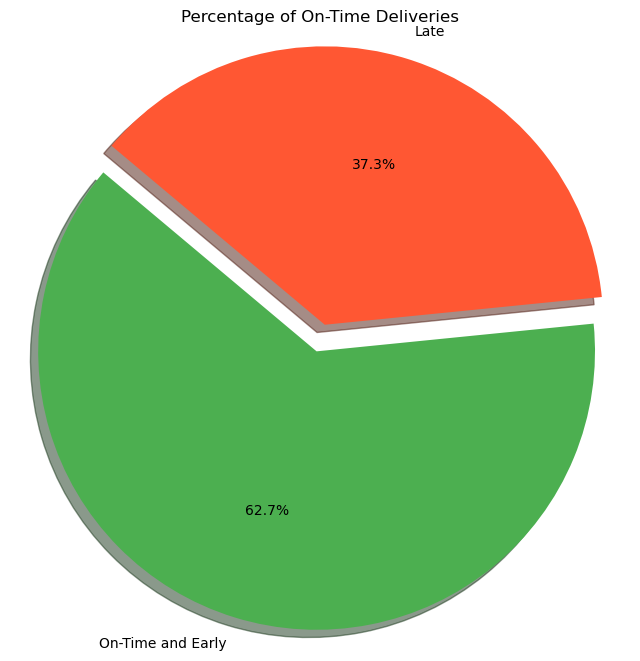

In [296]:
# Pie chart for on-time vs. late deliveries
labels = ['On-Time and Early', 'Late']
sizes = [percentage_on_time, 100 - percentage_on_time]
colors = ['#4CAF50', '#FF5733']
explode = (0.1, 0)  # explode the 1st slice

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Percentage of On-Time Deliveries')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()



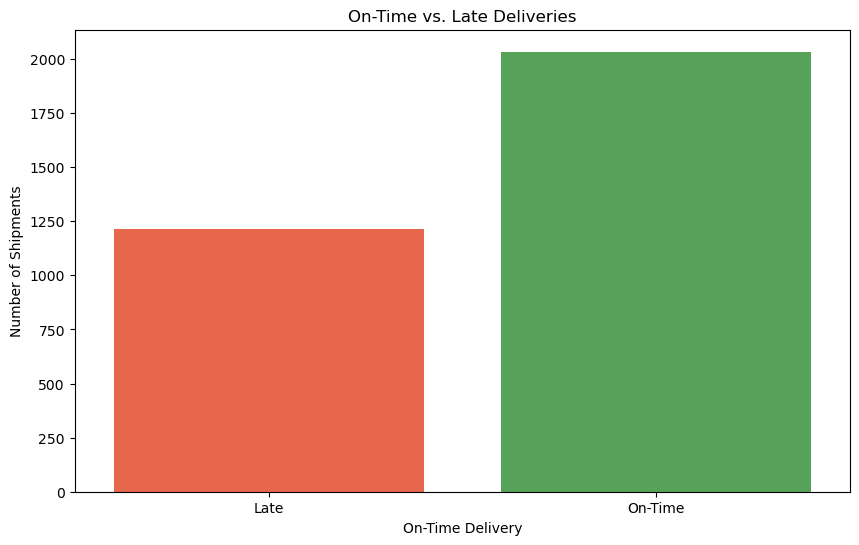

In [300]:
# Bar chart for on-time vs. late deliveries
on_time_delivery_counts = final_df['Total_On-Time_Deliveries'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=on_time_delivery_counts.index, y=on_time_delivery_counts.values, palette=['#FF5733','#4CAF50'])
plt.xlabel('On-Time Delivery')
plt.ylabel('Number of Shipments')
plt.title('On-Time vs. Late Deliveries')
plt.xticks([0, 1], ['Late', 'On-Time'])
plt.show()

# Task 2
Timely communication of potential delays is crucial for shippers. During the 3-month period from 1st Oct to 31st Dec 2023, which shipper(s) should be notified automatically regarding potential late delivery of which shipments, and at what times?

In [303]:
# Identify potential late deliveries
potential_late_shipments = filtered_df[(filtered_df['ACTUAL_DELIVERY_TIME']>=filtered_df['LAST_DELIVERY_SCHEDULE_LATEST']) & 
            (filtered_df['Total_On-Time_Deliveries']== False)]

In [305]:
potential_late_shipments.head()

,PROJECT_ID,SHIPMENT_NUMBER,CARRIER_DISPLAY_ID,VEHICLE_SIZE,VEHICLE_BUILD_UP,FIRST_COLLECTION_POST_CODE,LAST_DELIVERY_POST_CODE,FIRST_COLLECTION_LATITUDE,FIRST_COLLECTION_LONGITUDE,LAST_DELIVERY_LATITUDE,...,ontime_delivery_location,beforetime_delivery_location,late_delivery_city,ontime_delivery_city,beforetime_delivery_city,delivery_month,delivery_day,delivery_dayofweek,Total_On-Time_Delivery_location,Total_On-Time_Delivery_city
3,40415fe3-e446-4d1e-b141-3698b0dc47f3,SEZHUK-231211-272127,CAUK000096,Tractor Unit,Curtain-Side 13.6M Trailer,HP22 5BL,NG31 7UH,51.779657,-0.772897,52.888113,...,None,None,South Kesteven,None,None,12,13,2,un-identified,un-identified
4,39a4e234-5d35-4d94-8e8a-b8bf6fe13953,SEZHUK-231025-256168,CAUK000155,Tractor Unit,Curtain Side,CV23 8BQ,G75 0ZZ,52.334853,-1.180450,55.735089,...,None,None,East Kilbride,None,None,11,8,2,un-identified,un-identified
6,39a4e234-5d35-4d94-8e8a-b8bf6fe13953,SEZHUK-231120-264422,CAUK000155,Tractor Unit,Curtain Side,CV23 8BQ,ML1 4UY,52.334853,-1.180450,55.825996,...,None,None,Holytown,None,None,12,9,5,un-identified,un-identified
8,eb7a9df0-4875-43d8-9060-c79c35eae2fb,SEZHUK-231126-266580,CAUK001068,Tractor Unit,Box 44ft,BD5 8LZ,RG19 4BQ,53.763558,-1.739636,51.398851,...,None,None,Thatcham,None,None,11,27,0,un-identified,un-identified
11,bad2a1c4-4cf3-4157-864f-ce161784831f,SEZHUK-231102-258924,CAUK000689,Tractor Unit,Curtain-Side 13.6M Trailer,PR7 7NA,NP26 3TS,53.686775,-2.672518,51.572820,...,None,None,Newport,None,None,11,4,5,un-identified,un-identified


In [307]:
potential_late_shipments.shape

(1212, 35)

In [309]:
potential_late_shipments.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1212 entries, 3 to 3241
Data columns (total 35 columns):
 #   Column                              Non-Null Count  Dtype              
---  ------                              --------------  -----              
 0   PROJECT_ID                          1212 non-null   object             
 1   SHIPMENT_NUMBER                     1212 non-null   object             
 2   CARRIER_DISPLAY_ID                  1212 non-null   object             
 3   VEHICLE_SIZE                        1212 non-null   object             
 4   VEHICLE_BUILD_UP                    1212 non-null   object             
 5   FIRST_COLLECTION_POST_CODE          1212 non-null   object             
 6   LAST_DELIVERY_POST_CODE             1211 non-null   object             
 7   FIRST_COLLECTION_LATITUDE           1212 non-null   float64            
 8   FIRST_COLLECTION_LONGITUDE          1212 non-null   float64            
 9   LAST_DELIVERY_LATITUDE              1212 non-n

In [311]:
# Threshold for sending notification (e.g., 30 minutes before the scheduled latest delivery time)
notification_threshold = pd.Timedelta(minutes=30)

potential_late_shipments['NOTIFICATION_TIME'] = potential_late_shipments['LAST_DELIVERY_SCHEDULE_LATEST']-notification_threshold

In [313]:
#Extract necessary columns for notification
notifications = potential_late_shipments[['SHIPMENT_NUMBER','LAST_DELIVERY_SCHEDULE_LATEST','ACTUAL_DELIVERY_TIME','NOTIFICATION_TIME','ON_TIME_DELIVERY']]

In [315]:
#Validating result
notifications.head()

,SHIPMENT_NUMBER,LAST_DELIVERY_SCHEDULE_LATEST,ACTUAL_DELIVERY_TIME,NOTIFICATION_TIME,ON_TIME_DELIVERY
3,SEZHUK-231211-272127,2023-12-13 16:00:00+00:00,2023-12-13 17:22:00+00:00,2023-12-13 15:30:00+00:00,False
4,SEZHUK-231025-256168,2023-11-07 23:59:00+00:00,2023-11-08 03:53:00+00:00,2023-11-07 23:29:00+00:00,False
6,SEZHUK-231120-264422,2023-12-08 23:59:00+00:00,2023-12-09 02:19:00+00:00,2023-12-08 23:29:00+00:00,False
8,SEZHUK-231126-266580,2023-11-27 10:33:01+00:00,2023-11-27 12:56:00+00:00,2023-11-27 10:03:01+00:00,False
11,SEZHUK-231102-258924,2023-11-04 11:25:00+00:00,2023-11-04 11:58:00+00:00,2023-11-04 10:55:00+00:00,False


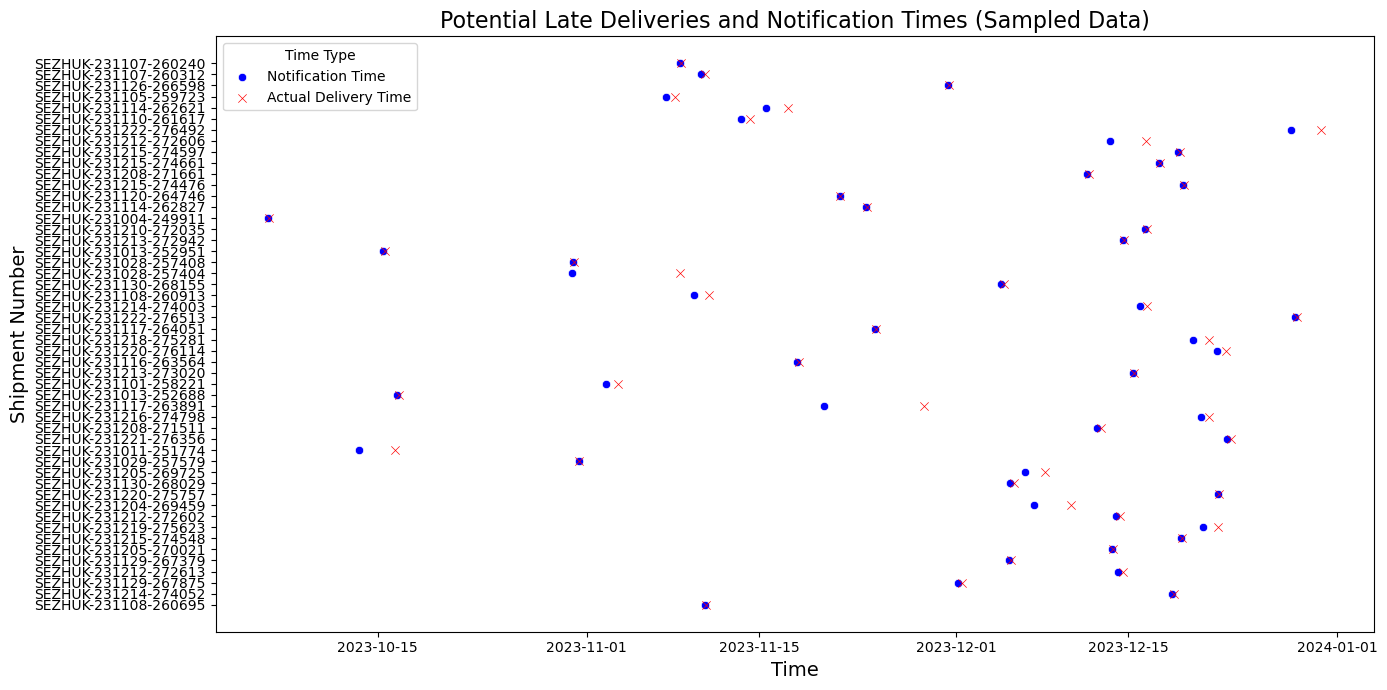

In [317]:
 #Sample data 
sample_size = 50  # Adjust the sample size as needed
if len(notifications) > sample_size:
    notifications_sample = notifications.sample(sample_size, random_state=1)
else:
    notifications_sample = notifications

# Scatter plot for potential late deliveries with a sample
plt.figure(figsize=(14, 7))
sns.scatterplot(data=notifications_sample, x='NOTIFICATION_TIME', y='SHIPMENT_NUMBER', marker='o', color='blue', label='Notification Time')
sns.scatterplot(data=notifications_sample, x='ACTUAL_DELIVERY_TIME', y='SHIPMENT_NUMBER', marker='x', color='red', label='Actual Delivery Time')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Shipment Number', fontsize=14)
plt.title('Potential Late Deliveries and Notification Times (Sampled Data)', fontsize=16)
plt.legend(title='Time Type', loc='upper left')
plt.tight_layout()
plt.show()

In [319]:
# Print notifications as an example (replace with your actual notification method)
if not notifications.empty:
    for index, notification in notifications.iterrows():
        print(f" Shipment {notification['SHIPMENT_NUMBER']} is potentially late. Notification time: {notification['NOTIFICATION_TIME']}")
else:
    print("No potential late deliveries found.")

 Shipment SEZHUK-231211-272127 is potentially late. Notification time: 2023-12-13 15:30:00+00:00
 Shipment SEZHUK-231025-256168 is potentially late. Notification time: 2023-11-07 23:29:00+00:00
 Shipment SEZHUK-231120-264422 is potentially late. Notification time: 2023-12-08 23:29:00+00:00
 Shipment SEZHUK-231126-266580 is potentially late. Notification time: 2023-11-27 10:03:01+00:00
 Shipment SEZHUK-231102-258924 is potentially late. Notification time: 2023-11-04 10:55:00+00:00
 Shipment SEZHUK-230927-247990 is potentially late. Notification time: 2023-10-04 03:00:00+00:00
 Shipment SEZHUK-231211-272331 is potentially late. Notification time: 2023-12-12 15:30:00+00:00
 Shipment SEZHUK-231121-265105 is potentially late. Notification time: 2023-11-23 10:25:00+00:00
 Shipment SEZHUK-230930-249028 is potentially late. Notification time: 2023-10-01 15:57:01+00:00
 Shipment SEZHUK-231211-272240 is potentially late. Notification time: 2023-12-21 13:00:00+00:00
 Shipment SEZHUK-231213-272973